In [1]:
import os
import numpy as np
import mne
print (mne.__version__)
from scipy.io import loadmat, savemat
from mne.io import read_raw_egi, read_raw_fif
#import matplotlib.pyplot as plt
#%matplotlib notebook
import sys
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
sys.path.insert(0, 'C:/Users/Antoine/github/MEG_pareidolia/python_scripts/Functions')
import MEG_pareidolia_utils
from MEG_pareidolia_utils import *


from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
from mne.io import read_raw_ctf, read_raw_fif
#from matplotlib.pyplot import plot as plt
#from matplotlib.pyplot import close as closefig
import mne
import numpy as np
from scipy.io import loadmat
import pandas as pd
import os
from IPython.display import clear_output
import time
import PARAMS
from PARAMS import *

1.2.2


In [2]:
'''The actual MEG experiment has 6 experimental blocs, followed by 2 sham-feedback bloc. 
The 8 blocs are preceded and followed by 1 resting-state eyes-open of 3 minutes'''

FOLDERPATH = r'D:\PsychoPy_MEG\BIDS_data' #You need to replace that path in order to indicate where the 
subj = '02'                                     #folder Pareidolia_BIDS is 
task = 'pareidolia'
#Here you can choose between run 1, 2, 3 or 4 (run 4 being the sham-feedback condition)
run = '2'
filename, filepath = get_pareidolia_bids(FOLDERPATH, subj, task, run, stage = 'meg', cond=None)

In [4]:
epochs_name, epochs_path = get_pareidolia_bids(FOLDERPATH, '00', 'pareidolia', '1', stage = 'epo_rt', cond=None)
epochs_name
epochs = mne.read_epochs(epochs_path)

Reading D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_rt.fif ...


C:\Users\Antoine\AppData\Local\Temp\ipykernel_8948\3603031019.py:3: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_rt.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_path)


    Found the data of interest:
        t =   -2000.00 ...    -500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
52 matching events found
No baseline correction applied
0 projection items activated


In [16]:
import scipy
data = epochs.get_data()[10][10]
data.shape
nperseg = None
precision = 1
sf=1000
noverlap=None
smooth = 1
average = "median"
if nperseg is None:
    mult = 1 / precision
    nfft = sf * mult
    nperseg = nfft/smooth
    
freqs, psd = scipy.signal.welch(
             data,
             sf,
             nfft=nfft,
             nperseg=nperseg,
             average=average,
             noverlap=noverlap
             )

FREQ_BANDS = {'delta':[2, 4], 'theta':[4, 8], 'alpha':[8, 12], 'beta':[12, 30], 'gamma':[30, 60]}
for key, value in FREQ_BANDS.items():
    idx_start = list(freqs).index(value[0])
    idx_end = list(freqs).index(value[1])
    avg_pwr = np.average(psd[idx_start:idx_end])
    



INDEX 2 4
key delta
value [2, 4]
INDEX 4 8
key theta
value [4, 8]
INDEX 8 12
key alpha
value [8, 12]
INDEX 12 30
key beta
value [12, 30]
INDEX 30 60
key gamma
value [30, 60]


501

In [153]:
from scipy.io import loadmat


def combine_metadata_PSD_complexity (subj_list, run_list, task, epo_stage=None, cp_stage=None, psd_stage=None, save=False,
                                    AVG_mode=False, DAT_df=None, LZ=None, bt_stage=None, save_multi=False, complex_imports=None):
    MEG_atlas = {'CL': list(range(0, 24)), 'FL': list(range(24, 57)), 'OL': list(range(57, 76)), 
             'PL': list(range(76, 97)), 'TL': list(range(97, 131)),
             'CR': list(range(131, 153)), 'FR': list(range(153, 186)), 'OR': list(range(186, 204)), 
             'PR': list(range(204, 226)), 'TR': list(range(226, 259)), 'CZ': list(range(259, 263)),
             'Fz': list(range(263, 266)), 'OZ': list(range(266, 269)), 'PZ': list(range(269, 270))
            }
    MEG_regions = list(MEG_atlas.keys())
    region_lists = []
    for r in MEG_regions:
        region_lists.append([MEG_atlas[r]][0])
    list_df_subj = []
    for s in subj_list:
        list_df_run = []
        for run in run_list:
            try:
                epo_name, epo_path = get_pareidolia_bids(FOLDERPATH, s, task, run, stage = epo_stage, cond=None)
                epochs = mne.read_epochs(epo_path)

                if cp_stage is not None:
                    cp_name, cp_path = get_pareidolia_bids(FOLDERPATH, s, task, run, stage = cp_stage, cond=None)
                    complexity = pd.read_csv(cp_path)
                    complexity = complexity.rename(columns={"Unnamed: 0": "trials", "Unnamed: 1": "electrodes"})
                print(int(run))

                if psd_stage is not None:
                    psd_name, psd_path = get_pareidolia_bids(FOLDERPATH, s, task, run, stage = psd_stage, cond=None)

                    PSD = loadmat(psd_path)
                    PSD = PSD['PSD']
                    PSD = np.moveaxis(PSD, 1, 2)
                    trials_df = []
                    for i in range(len(PSD)):
                        df_ = pd.DataFrame(PSD[i]).reset_index().rename(columns={"index": "electrodes", 
                                                                                0:'delta',
                                                                                1:'theta',
                                                                                2:'alpha',
                                                                                3:'low_beta',
                                                                                4:'high_beta',
                                                                                5:'gamma1',
                                                                                6:'gamma2',})
                        df_['trials'] = i
                        if AVG_mode == 'whole':
                            df_ = df_.groupby(by='trials').mean().reset_index()
                        #print(df_)
                        trials_df.append(df_)
                    PSD_df = pd.concat(trials_df)

                if task == 'pareidolia':
                    metadata = epochs.metadata
                    metadata = metadata.reset_index(drop=True)
                    metadata['trials'] = range(len(metadata))
                
                # Get pareidolia scores to append on RS dataframe.
                if task == 'RS':
                    data = pd.read_csv('df_ALL_metadata_MEG_sub00to11_epo_RT_before.csv')
                    data_participant = data.groupby(by='participant').mean().reset_index()
                    data_participant = data_participant[['n_obj', 'parei', 'participant']]
                    data_participant
                

                if psd_stage is not None and cp_stage is not None:
                    complexity['bloc'] = int(run)
                    complexity['participant'] = int(s)
                    if task == 'pareidolia':
                        total_df_ = pd.merge(complexity, metadata, on='trials')
                        total_df = pd.merge(total_df_, PSD_df, on=['trials', 'electrodes'])
                    if task == 'RS':
                        total_df = pd.merge(complexity, PSD_df, on=['trials', 'electrodes'])
                    

                if psd_stage is None and cp_stage is not None:
                    complexity['bloc'] = int(run)
                    complexity['participant'] = int(s)               
                    if task == 'pareidolia':
                        total_df = pd.merge(complexity, metadata, on='trials')
                    if task == 'RS':
                        total_df = complexity


                if psd_stage is not None and cp_stage is None:
                    PSD_df['bloc'] = int(run)
                    PSD_df['participant'] = int(s)
                    if task == 'pareidolia':
                        total_df = pd.merge(PSD_df, metadata, on='trials')
                    if task == 'RS':
                        total_df = PSD_df


                if LZ is not None:
                    LZ_file, LZ_path = get_pareidolia_bids(FOLDERPATH, s, task, run, stage = 'array_comp_LZ')
                    LZ = np.load(LZ_path+'.npy')
                    LZ.shape


                    trials_df = []
                    for t in range(len(LZ)):
                        df_ = pd.DataFrame(LZ[t]).reset_index().rename(columns={'index':'electrodes', 0: "LZ"})
                        df_['trials'] = t
                        #df_['bloc'] = bloc
                        #df_['participant'] = subj
                        trials_df.append(df_)
                    LZ_df = pd.concat(trials_df)  
                    total_df = pd.merge(total_df, LZ_df, on=['trials', 'electrodes'])

                if complex_imports is not None:
                    for names in complex_imports:
                        df_ = total_df
                        print(names[0])
                        total_df = import_complexity(names[0], names[1], df_, subj=s, run=run)

                if bt_stage is not None:
                    try:
                        bt_file, bt_path = get_pareidolia_bids(FOLDERPATH, s, task, run, stage = bt_stage)
                        bt_df = pd.read_csv(bt_path)
                        total_df = pd.merge(total_df, bt_df, on=['trials', 'electrodes'])
                    except:
                        pass

                list_df_run.append(total_df)
            except FileNotFoundError:
                pass
        df_temp = pd.concat(list_df_run)
        list_df_subj.append(df_temp)
    df_final = pd.concat(list_df_subj)
    if task == 'RS':
        df_final['bloc'] = df_final['bloc']-1
    if DAT_df is not None:
        df_final = pd.merge(df_final, DAT_df, on='participant')
        
    df_final = pd.merge(df_final, data_participant, on='participant')
    if AVG_mode == 'regions':
        for r_list, r_name in zip(region_lists, MEG_regions):
            for j in r_list:
                df_final.loc[df_final['electrodes'] == j, 'region'] = r_name
        df_final = df_final.groupby(by=['region','trials', 'participant', 'bloc']).mean().reset_index()
    if save is True:
        save_name = 'df_ALL_metadata_MEG_sub{}to{}_{}.csv'.format(subj_list[0], subj_list[-1], epo_stage)
        df_final.to_csv(save_name, index=False)
    if save_multi is True:
        for e in range(0, len(total_df['electrodes'].unique())):
            df = total_df.loc[total_df['electrodes'] == e]
            df.to_csv('12participants_MEG_electrodes_sub_'+str(e)+'.csv', index=False)
    return df_final

'''filename = 'array_comp_hurst'
name = 'hurst'
'''

def import_complexity (filename, name, df2merge, subj=None, task='pareidolia', run='1'):
    file, path = get_pareidolia_bids(FOLDERPATH, subj, task, run, stage = filename)
    cp = np.load(path+'.npy')
    trials_df = []
    for t in range(len(cp)):
        df_ = pd.DataFrame(cp[t]).reset_index().rename(columns={'index':'electrodes', 0: name})
        df_['trials'] = t
        #df_['bloc'] = bloc
        #df_['participant'] = subj
        trials_df.append(df_)
    df = pd.concat(trials_df)  
    total_df = pd.merge(df2merge, df, on=['trials', 'electrodes'])
    return total_df

In [45]:
DAT_df

participant        DAT
0             0  91.554412
1             1  89.848049
2             2  82.436589
3             3  91.143189
4             4  81.296306
5             5  88.203262
6             6  91.930462
7             7  89.528963
8             8  84.335070
9             9        NaN
10           10  86.825428
11           11  91.399824

In [75]:
new_DAT

[0.8937423135467496,
 0.571230717836981,
 0.09376534850934609,
 0.7426476132961217,
 0.0,
 0.4010244927647397,
 1.0,
 0.5340001719621974,
 0.19478283915696887,
 nan,
 0.31203695113377167,
 0.8103667722986299]

In [80]:
import seaborn as sbn
from scipy.stats import shapiro 
from scipy.stats import kstest
from sklearn.preprocessing import quantile_transform

DAT_df = pd.read_csv('../Questionnaire_data/DAT_MEG.csv')
#DAT = DAT_df['DAT']

DAT_df.insert(len(DAT_df.columns), 'DAT_Sqrt',
         np.sqrt(DAT_df.iloc[:,1]))

DAT = DAT_df['DAT']
DAT = np.array(DAT)
DAT = np.expand_dims(DAT, axis=1)
#DAT = [abs(x) - np.mean(DAT) for x in DAT]
DAT = quantile_transform(DAT, n_quantiles=50, random_state=0, copy=True)
new_DAT = []
for i in range(len(DAT)):
    new_DAT.append(DAT[i][0])
new_DAT = [x for x in new_DAT if str(x) != 'nan']
kstest(new_DAT, 'norm')
#shapiro(DAT)
#sbn.distplot()


C:\Users\Antoine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_data.py:2588: UserWarning: n_quantiles (50) is greater than the total number of samples (12). n_quantiles is set to n_samples.
  warnings.warn(


KstestResult(statistic=0.5, pvalue=0.004565178595441963)

C:\Users\Antoine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

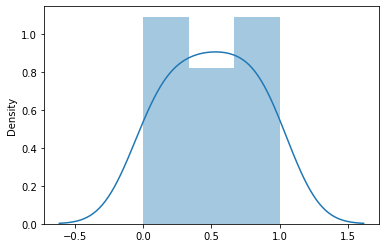

In [81]:
sbn.distplot(new_DAT)

In [157]:
subj_list = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11']
#subj_list = ['04', '05', '06', '07']
run_list = ['1', '2', '3', '4', '5', '6']
run_list = ['1', '2', '3', '4', '5', '6']
task = 'RS'
DAT_df = pd.read_csv('DAT_MEG.csv')

cp_imports = [['array_comp_hurst', 'hurst'], ['array_comp_LZ', 'LZ']]
#cp_imports = [['array_comp_hurst', 'hurst']]
df_total = combine_metadata_PSD_complexity(subj_list, run_list, task,
                                           epo_stage='epo_RS_3sec', cp_stage='Complexity_fast_RS_3sec', psd_stage='PSD_RS_3sec',
                                          save=False, AVG_mode='none', DAT_df=DAT_df, LZ=None, bt_stage=None,
                                          save_multi=False, complex_imports=None)
#df_total = pd.merge(df_total, data_participant, on='participant')
'''for e in range(0, 270):
    df = df_total.loc[df_total['electrodes'] == e]
    df.to_csv('12participants_epo_LONG_MEG_electrodes_elec_'+str(e)+'.csv', index=False)'''

Reading D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-RS_run-1_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-RS_run-1_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)


    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
1
Reading D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-RS_run-2_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-RS_run-2_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)


    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
2
Reading D:\PsychoPy_MEG\BIDS_data\sub-01\ses-recording\meg\sub-01_ses-recording_task-RS_run-1_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-RS_run-3_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-RS_run-4_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-RS_run-5_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipy

    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
1
Reading D:\PsychoPy_MEG\BIDS_data\sub-01\ses-recording\meg\sub-01_ses-recording_task-RS_run-2_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-01\ses-recording\meg\sub-01_ses-recording_task-RS_run-2_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)


    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
2
Reading D:\PsychoPy_MEG\BIDS_data\sub-02\ses-recording\meg\sub-02_ses-recording_task-RS_run-1_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-01\ses-recording\meg\sub-01_ses-recording_task-RS_run-3_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-01\ses-recording\meg\sub-01_ses-recording_task-RS_run-4_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-01\ses-recording\meg\sub-01_ses-recording_task-RS_run-5_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipy

    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
1
Reading D:\PsychoPy_MEG\BIDS_data\sub-02\ses-recording\meg\sub-02_ses-recording_task-RS_run-2_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-02\ses-recording\meg\sub-02_ses-recording_task-RS_run-2_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)


    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
2
Reading D:\PsychoPy_MEG\BIDS_data\sub-03\ses-recording\meg\sub-03_ses-recording_task-RS_run-2_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-02\ses-recording\meg\sub-02_ses-recording_task-RS_run-3_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-02\ses-recording\meg\sub-02_ses-recording_task-RS_run-4_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-02\ses-recording\meg\sub-02_ses-recording_task-RS_run-5_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipy

    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
2
Reading D:\PsychoPy_MEG\BIDS_data\sub-04\ses-recording\meg\sub-04_ses-recording_task-RS_run-1_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-03\ses-recording\meg\sub-03_ses-recording_task-RS_run-3_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-03\ses-recording\meg\sub-03_ses-recording_task-RS_run-4_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-03\ses-recording\meg\sub-03_ses-recording_task-RS_run-5_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipy

    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
1
Reading D:\PsychoPy_MEG\BIDS_data\sub-04\ses-recording\meg\sub-04_ses-recording_task-RS_run-2_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-04\ses-recording\meg\sub-04_ses-recording_task-RS_run-2_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)


    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
2
Reading D:\PsychoPy_MEG\BIDS_data\sub-05\ses-recording\meg\sub-05_ses-recording_task-RS_run-1_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-04\ses-recording\meg\sub-04_ses-recording_task-RS_run-3_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-04\ses-recording\meg\sub-04_ses-recording_task-RS_run-4_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-04\ses-recording\meg\sub-04_ses-recording_task-RS_run-5_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipy

    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
1
Reading D:\PsychoPy_MEG\BIDS_data\sub-05\ses-recording\meg\sub-05_ses-recording_task-RS_run-2_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-05\ses-recording\meg\sub-05_ses-recording_task-RS_run-2_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)


    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
2
Reading D:\PsychoPy_MEG\BIDS_data\sub-06\ses-recording\meg\sub-06_ses-recording_task-RS_run-1_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-05\ses-recording\meg\sub-05_ses-recording_task-RS_run-3_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-05\ses-recording\meg\sub-05_ses-recording_task-RS_run-4_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-05\ses-recording\meg\sub-05_ses-recording_task-RS_run-5_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipy

    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
1
Reading D:\PsychoPy_MEG\BIDS_data\sub-06\ses-recording\meg\sub-06_ses-recording_task-RS_run-2_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-06\ses-recording\meg\sub-06_ses-recording_task-RS_run-2_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)


    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
2


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-06\ses-recording\meg\sub-06_ses-recording_task-RS_run-3_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-06\ses-recording\meg\sub-06_ses-recording_task-RS_run-4_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-06\ses-recording\meg\sub-06_ses-recording_task-RS_run-5_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipy

Reading D:\PsychoPy_MEG\BIDS_data\sub-07\ses-recording\meg\sub-07_ses-recording_task-RS_run-2_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-07\ses-recording\meg\sub-07_ses-recording_task-RS_run-2_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)


    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
2
Reading D:\PsychoPy_MEG\BIDS_data\sub-08\ses-recording\meg\sub-08_ses-recording_task-RS_run-2_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-07\ses-recording\meg\sub-07_ses-recording_task-RS_run-3_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-07\ses-recording\meg\sub-07_ses-recording_task-RS_run-4_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-07\ses-recording\meg\sub-07_ses-recording_task-RS_run-5_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipy

    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
2
Reading D:\PsychoPy_MEG\BIDS_data\sub-09\ses-recording\meg\sub-09_ses-recording_task-RS_run-2_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-08\ses-recording\meg\sub-08_ses-recording_task-RS_run-3_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-08\ses-recording\meg\sub-08_ses-recording_task-RS_run-4_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-08\ses-recording\meg\sub-08_ses-recording_task-RS_run-5_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipy

    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
2
Reading D:\PsychoPy_MEG\BIDS_data\sub-10\ses-recording\meg\sub-10_ses-recording_task-RS_run-1_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-09\ses-recording\meg\sub-09_ses-recording_task-RS_run-3_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-09\ses-recording\meg\sub-09_ses-recording_task-RS_run-4_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-09\ses-recording\meg\sub-09_ses-recording_task-RS_run-5_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipy

    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
1
Reading D:\PsychoPy_MEG\BIDS_data\sub-10\ses-recording\meg\sub-10_ses-recording_task-RS_run-2_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-10\ses-recording\meg\sub-10_ses-recording_task-RS_run-2_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)


    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
2
Reading D:\PsychoPy_MEG\BIDS_data\sub-11\ses-recording\meg\sub-11_ses-recording_task-RS_run-1_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-10\ses-recording\meg\sub-10_ses-recording_task-RS_run-3_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-10\ses-recording\meg\sub-10_ses-recording_task-RS_run-4_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-10\ses-recording\meg\sub-10_ses-recording_task-RS_run-5_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipy

    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
1
Reading D:\PsychoPy_MEG\BIDS_data\sub-11\ses-recording\meg\sub-11_ses-recording_task-RS_run-2_epo_RS_3sec.fif ...


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-11\ses-recording\meg\sub-11_ses-recording_task-RS_run-2_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)


    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
2


<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-11\ses-recording\meg\sub-11_ses-recording_task-RS_run-3_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-11\ses-recording\meg\sub-11_ses-recording_task-RS_run-4_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipython-input-153-648782f46180>:22: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-11\ses-recording\meg\sub-11_ses-recording_task-RS_run-5_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)
<ipy

"for e in range(0, 270):\n    df = df_total.loc[df_total['electrodes'] == e]\n    df.to_csv('12participants_epo_LONG_MEG_electrodes_elec_'+str(e)+'.csv', index=False)"

In [128]:
df_total.to_csv('df_ALL_metadata_MEG_sub00to11_epo_RS_3sec.csv')

In [19]:
epo_name, epo_path = get_pareidolia_bids(FOLDERPATH, '04', 'RS', '2', stage = 'epo_RS_3sec', cond=None)
epochs = mne.read_epochs(epo_path)
epochs


tmin = 0
tmax = 8
epochs = epochs.crop(tmin, tmax)

epochs

Reading D:\PsychoPy_MEG\BIDS_data\sub-04\ses-recording\meg\sub-04_ses-recording_task-RS_run-2_epo_RS_3sec.fif ...
    Found the data of interest:
        t =   -1000.00 ...    3000.00 ms
        0 CTF compensation matrices available


C:\Users\Antoine\AppData\Local\Temp/ipykernel_21200/3384094663.py:2: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-04\ses-recording\meg\sub-04_ses-recording_task-RS_run-2_epo_RS_3sec.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)


Not setting metadata
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated


C:\Users\Antoine\AppData\Local\Temp/ipykernel_21200/3384094663.py:8: RuntimeWarning: tmax is not in epochs time interval. tmax is set to epochs.tmax
  epochs = epochs.crop(tmin, tmax)


<EpochsFIF |  58 events (all good), 0 - 3 sec, baseline -1 – 0 sec (baseline period was cropped after baseline correction), ~430.5 MB, data loaded,
 'RS': 58>

In [ ]:
bt_var = 'LZ'
epo_name, epo_path = get_pareidolia_bids(FOLDERPATH, '00', 'pareidolia', '2', stage = 'epo_long_meta', cond=None)
epochs = mne.read_epochs(epo_path)
ch_xy = epochs.pick_types(meg=True, ref_meg=False).info
for p in data['participant'].unique():
    df = data[data['participant'] == p]
    df = df.groupby(by='electrodes').mean().reset_index()
    value_to_plot = df[bt_var]
    vmin=np.min(value_to_plot)
    vmax=np.max(value_to_plot)
    reportname, reportpath = get_pareidolia_bids(FOLDERPATH, '00',
                                                 'pareidolia', '-', stage = 'fig_BT_'+bt_var+'p'+str(p))
    fig, ax = topoplot(value_to_plot, ch_xy, vmin=vmin, vmax=vmax,
                       showtitle=True, titles='Distribution of '+bt_var+' p'+str(p), mask = None,
                       figpath = reportpath, ax_title=bt_var)

In [84]:
p = stats.pearsonr(df[variables[0]], df[variables[1]])


0.665425637115511

<IPython.core.display.Javascript object>


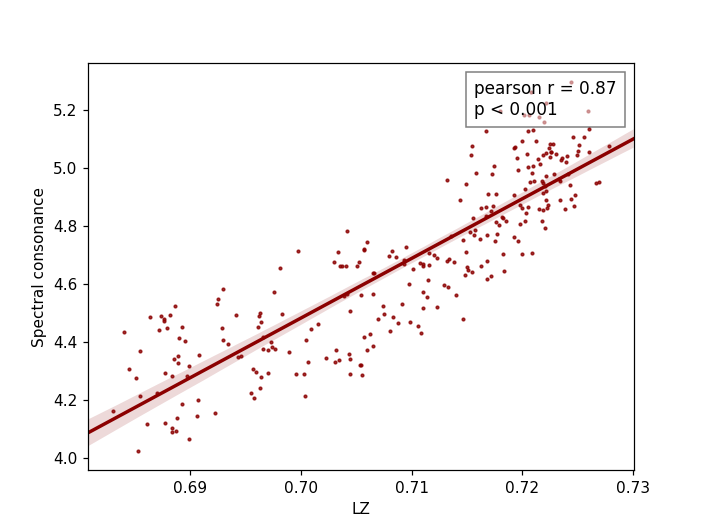

In [10]:
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
import seaborn as sbn
#df = data[data['participant'] == 11]
#plt.close('all')
variables = ['LZ', 'harmsim']
df = data.groupby(by='electrodes').mean().reset_index()
corr = stats.pearsonr(df[variables[0]], df[variables[1]])
corr = [np.round(x, 2) for x in corr]
sbn.regplot(df[variables[0]], df[variables[1]], scatter_kws={'s':3}, color='darkred')
if corr[1] < 0.001:
    text_box = AnchoredText('pearson r = '+str(corr[0])+'\np < 0.001 ', frameon=True, loc=1, pad=0.5,prop=dict(size=11))
else:
    text_box = AnchoredText('pearson r = '+str(corr[0])+'\np = '+str(corr[1]), frameon=True, loc=1, pad=0.5,prop=dict(size=14))
plt.setp(text_box.patch, facecolor='white', alpha=0.5,width=6, height=6)
plt.gca().add_artist(text_box)
plt.ylabel('Spectral consonance')
plt.savefig('corr_avg_'+str(variables))

In [4]:
epo_name, epo_path = get_pareidolia_bids(FOLDERPATH, '00', 'pareidolia', '2', stage = 'epo_RT', cond=None)
epochs = mne.read_epochs(epo_path)
ch_xy = epochs.pick_types(meg=True, ref_meg=False).info

<ipython-input-4-6a8492b8ea76>:2: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-2_epo_RT.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)


Reading D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-2_epo_RT.fif ...
    Found the data of interest:
        t =   -2000.00 ...    -500.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 7 columns
52 matching events found
No baseline correction applied
0 projection items activated


### Correlation matrix between harmonicity metrics using Fisher transformation to average coefficient across subjects

In [135]:
import seaborn as sbn
import matplotlib.pyplot as plt
plt.clf()
df_total['sum_by_product'] = df_total['cons']
corr_tot = []
fz_tot = []
for subj in df_total['participant'].unique():
    data_corr = df_total[df_total['participant'] == subj]
    data_corr = data_corr[['tenney', 'harmsim', 'harm_fit', 'sum_p_q', 'sum_by_product', 'subharm_tension']]
    corr_ = data_corr.corr().round(2)
    corr_tot.append(corr_)
    fz_tot.append(np.arctanh(corr_))

averages = pd.concat([each.stack() for each in fz_tot],axis=1)\
             .apply(lambda x:x.mean(),axis=1)\
             .unstack()
r_finals = np.tanh(averages)
matrix = np.triu(corr_)
#ax.set(xticks=[1, 2, 3, 4, 5, 6], xticklabels=['tenney', 'harmsim', 'euler', 'harm_fit', 'cons', 'sum_p_q'])
g = sbn.heatmap(r_finals, cmap='icefire',
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, mask=matrix)

g.set_xticklabels(g.get_xticklabels(), rotation = 15, fontsize = 10)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 10)
#bottom, top = g.get_ylim()
#g.set_ylim(bottom -0.5, top - 0.5)
plt.savefig('harmonicity_corr_matrix_fisher.png', dpi=300)

<ipython-input-135-e1601636f205>:12: RuntimeWarning: divide by zero encountered in arctanh
  fz_tot.append(np.arctanh(corr_))
<ipython-input-135-e1601636f205>:12: RuntimeWarning: divide by zero encountered in arctanh
  fz_tot.append(np.arctanh(corr_))
<ipython-input-135-e1601636f205>:12: RuntimeWarning: divide by zero encountered in arctanh
  fz_tot.append(np.arctanh(corr_))
<ipython-input-135-e1601636f205>:12: RuntimeWarning: divide by zero encountered in arctanh
  fz_tot.append(np.arctanh(corr_))
<ipython-input-135-e1601636f205>:12: RuntimeWarning: divide by zero encountered in arctanh
  fz_tot.append(np.arctanh(corr_))
<ipython-input-135-e1601636f205>:12: RuntimeWarning: divide by zero encountered in arctanh
  fz_tot.append(np.arctanh(corr_))
<ipython-input-135-e1601636f205>:12: RuntimeWarning: divide by zero encountered in arctanh
  fz_tot.append(np.arctanh(corr_))
<ipython-input-135-e1601636f205>:12: RuntimeWarning: divide by zero encountered in arctanh
  fz_tot.append(np.arctanh(

### Distribution of metrics in the sensor space (grand average)

Reading D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-2_epo_long_meta.fif ...


<ipython-input-55-64592637fb05>:4: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-2_epo_long_meta.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path)


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 7 columns
52 matching events found
No baseline correction applied
0 projection items activated


<IPython.core.display.Javascript object>


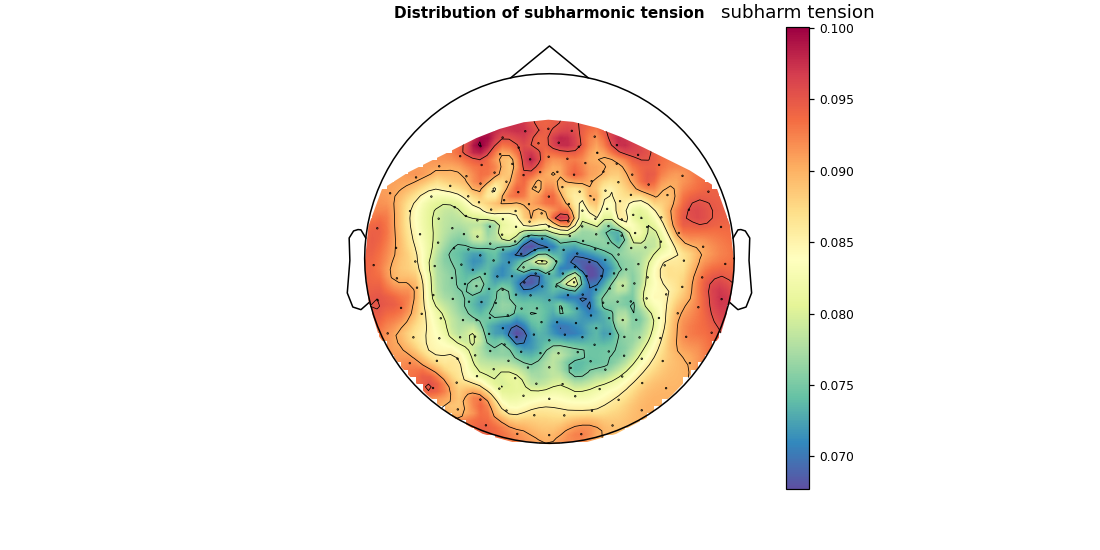

In [55]:
data = pd.read_csv('df_ALL_metadata_MEG_DAT_sub04to07_Complexity_long_AVG.csv')
bt_var = 'subharm_tension'
epo_name, epo_path = get_pareidolia_bids(FOLDERPATH, '00', 'pareidolia', '2', stage = 'epo_long_meta', cond=None)
epochs = mne.read_epochs(epo_path)
ch_xy = epochs.pick_types(meg=True, ref_meg=False).info

df = data.groupby(by='electrodes').mean().reset_index()
value_to_plot = df[bt_var]
vmin=np.min(value_to_plot)
vmax=np.max(value_to_plot)
reportname, reportpath = get_pareidolia_bids(FOLDERPATH, '00',
                                             'pareidolia', '-', stage = 'fig_BT_'+bt_var)
fig, ax = topoplot(value_to_plot, ch_xy, vmin=vmin, vmax=vmax,
                   showtitle=True, titles='Distribution of subharmonic tension', mask = None,
                   figpath = reportpath, ax_title='subharm tension')

In [9]:
stats.pearsonr(df[variables[0]], df[variables[1]])

(0.8058203479679423, 6.223746881434878e-63)

In [26]:
np.min(df[variables[0]])

3.6000481411639647

[[ 1.         -0.02149016]
 [-0.02149016  1.        ]]


<IPython.core.display.Javascript object>


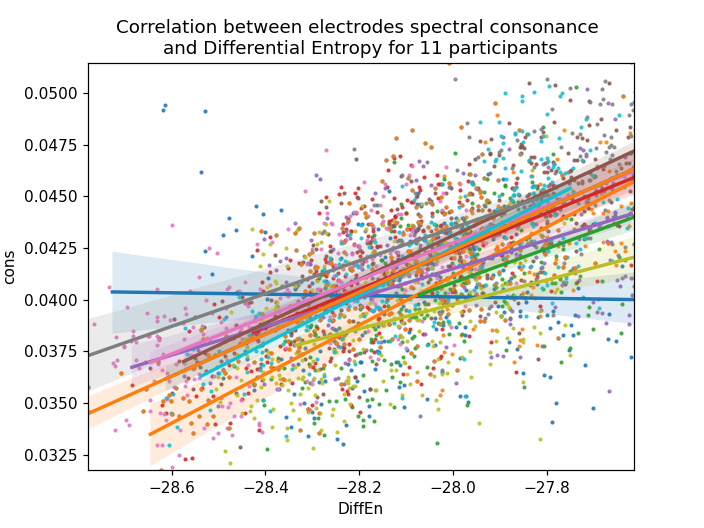

[[1.         0.73304421]
 [0.73304421 1.        ]]
[[1.        0.5145269]
 [0.5145269 1.       ]]
[[1.         0.58696834]
 [0.58696834 1.        ]]
[[1.         0.66556036]
 [0.66556036 1.        ]]
[[1.         0.74488749]
 [0.74488749 1.        ]]
[[1.        0.6371837]
 [0.6371837 1.       ]]
[[1.         0.54770686]
 [0.54770686 1.        ]]
[[1.         0.38230923]
 [0.38230923 1.        ]]
[[1.         0.76005429]
 [0.76005429 1.        ]]
[[1.         0.66542564]
 [0.66542564 1.        ]]


In [78]:
import seaborn as sbn
import matplotlib.pyplot as plt
variables = ['DiffEn', 'cons']
for p in data['participant'].unique():
#for p in [1, 2, 8]:
    if p != 3:
        df = data[data['participant'] == p]
        df = df.groupby(by='electrodes').mean().reset_index()
        corr = np.corrcoef(df[variables[0]], df[variables[1]])
        print(corr)
        sbn.regplot(df[variables[0]], df[variables[1]], scatter_kws={'s':3})
        plt.ylabel('spectral consonance')
        plt.title('Correlation between electrodes spectral consonance \nand Differential Entropy for 11 participants')
        plt.ylim(np.min(df[variables[1]]), np.max(df[variables[1]]))
        plt.xlim(np.min(df[variables[0]]), np.max(df[variables[0]]))
        plt.savefig('corr_'+str(variables))
        plt.close('all')

In [ ]:
import seaborn as sbn
import matplotlib.pyplot as plt
variables = ['DiffEn', 'cons']
for p in data['participant'].unique():
#for p in [1, 2, 8]:
    if p != 3:
        df = data[data['participant'] == p]
        for e in data['electrodes'].unique()
        df = df.groupby(by='electrodes').mean().reset_index()
        corr = np.corrcoef(df[variables[0]], df[variables[1]])
        print(corr)
        

## Correlations in the sensor space for each subject

<IPython.core.display.Javascript object>


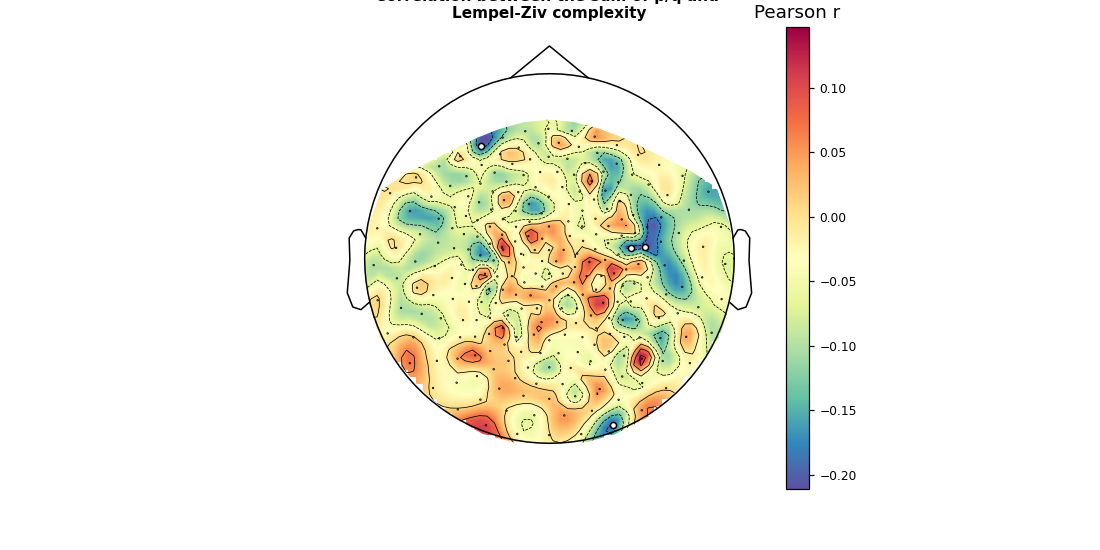

<IPython.core.display.Javascript object>


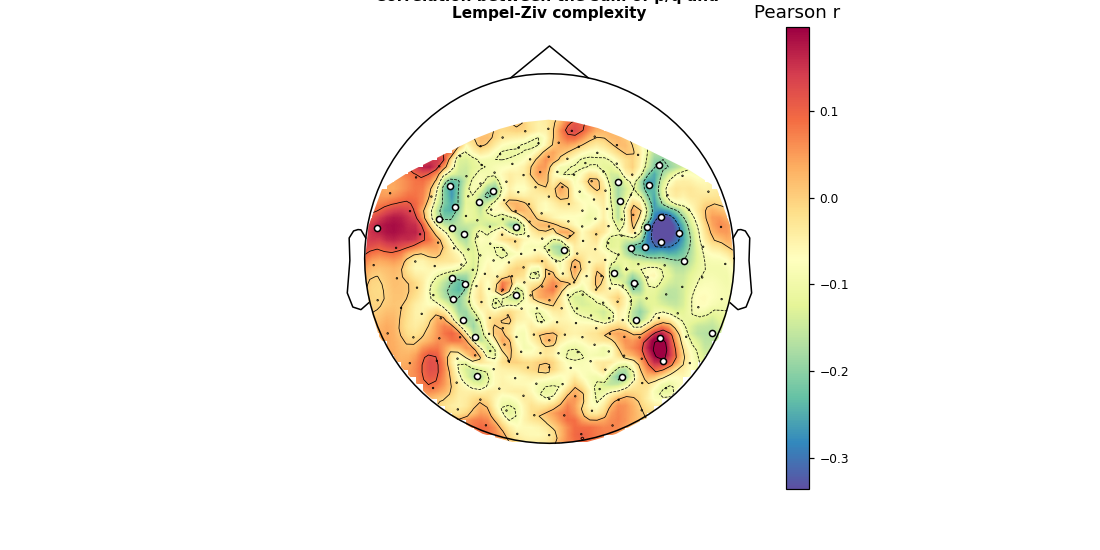

In [64]:
import seaborn as sbn
from statsmodels.stats.multitest import fdrcorrection
variables = ['LZ', 'tenney']
#data_ = data[data['subharm_tension'].notna()]
for p in data['participant'].unique():
    if p != 3:
        if p == 4 or p == 5:
            df = data_[data_['participant'] == p]
            #sbn.regplot(df_[variables[0]], df_[variables[1]])
            value_to_plot = []
            p_vals = []
            for e in df['electrodes'].unique():
                df_ = df[df['electrodes'] == e]
                corr = stats.pearsonr(df_[variables[0]], df_[variables[1]])
                value_to_plot.append(corr[0])
                p_vals.append(corr[1])
            vmin=np.min(value_to_plot)
            vmax=np.max(value_to_plot)
            reportname, reportpath = get_pareidolia_bids(FOLDERPATH, '00',
                                                         'pareidolia', '-', stage = 'fig_BT_'+str(variables)+'_'+str(p))
            _, p_vals = fdrcorrection(p_vals, alpha=0.05, method='indep')
            mask = p_values_boolean_1d(p_vals)
            fig, ax = topoplot(value_to_plot, ch_xy, vmin=vmin, vmax=vmax,
                               showtitle=True, titles='Correlation between the sum of p/q and \nLempel-Ziv complexity', mask = mask,
                               figpath = reportpath, ax_title='Pearson r')

In [40]:
data.columns

Index(['trials', 'electrodes', 'index', 'DiffEn', 'FI', 'Hjorth', 'KFD', 'PEn',
       'PFD', 'RR', 'SFD', 'SVDEn', 'ShanEn', 'SpEn', 'bloc', 'participant',
       'FD', 'FD_class', 'n_obj', 'n_obj_class', 'parei', 'contrast',
       'earlyVSlate', 'delta', 'theta', 'alpha', 'low_beta', 'high_beta',
       'gamma1', 'gamma2', 'LZ', 'hurst', 'sum_p_q', 'sum_distinct_intervals',
       'metric_3', 'sum_p_q_for_all_intervals', 'sum_q_for_all_intervals',
       'harm_sim', 'matrix_harm_sim', 'matrix_cons', 'matrix_denom', 'cons',
       'euler', 'tenney', 'harm_fit', 'harmsim', 'DAT'],
      dtype='object')

3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317
3317


<IPython.core.display.Javascript object>


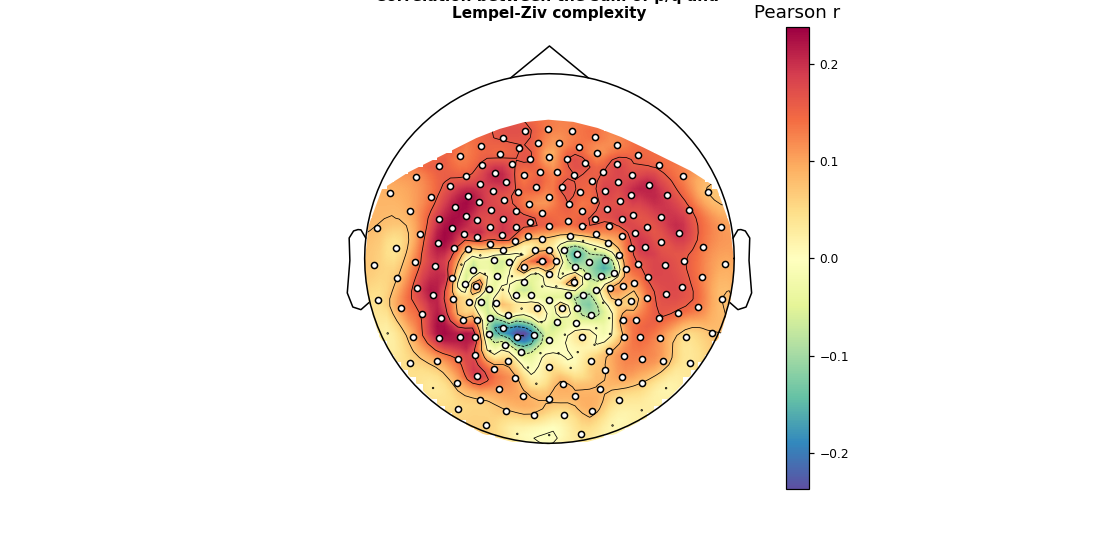

In [53]:
import seaborn as sbn
from statsmodels.stats.multitest import fdrcorrection
variables = ['LZ', 'harm_fit']

#sbn.regplot(df_[variables[0]], df_[variables[1]])
value_to_plot = []
p_vals = []
df = data.drop(data[data.participant == 3].index)
for e in df['electrodes'].unique():
    df_ = df[df['electrodes'] == e]
    print(len(df_[variables[0]]))
    corr = stats.pearsonr(df_[variables[0]], df_[variables[1]])
    value_to_plot.append(corr[0])
    p_vals.append(corr[1])
vmin=np.min(value_to_plot)
vmax=np.max(value_to_plot)
print(vmin, vmax)
if np.abs(vmin) > vmax:
    vmax = np.abs(vmin)
if vmax > np.abs(vmin):
    vmin = -vmax
    
print(vmin, vmax)  
reportname, reportpath = get_pareidolia_bids(FOLDERPATH, '00',
                                             'pareidolia', '-', stage = 'fig_BT_'+str(variables))
_, p_vals = fdrcorrection(p_vals, alpha=0.05, method='indep')
mask = p_values_boolean_1d(p_vals)
fig, ax = topoplot(value_to_plot, ch_xy, vmin=vmin, vmax=vmax,
                   showtitle=True, titles='Correlation between the sum of p/q and \nLempel-Ziv complexity', mask = mask,
                   figpath = reportpath, ax_title='Pearson r')

In [ ]:
subj='00'
LZ_file, LZ_path = get_pareidolia_bids(FOLDERPATH, subj, task, run, stage = 'array_comp_LZ')
LZ = np.load(LZ_path+'.npy')
LZ.shape


trials_df = []
for t in range(len(LZ)):
    df_ = pd.DataFrame(LZ[t]).reset_index().rename(columns={'index':'electrodes', 0: "LZ"})
    df_['trials'] = t

        #df_['bloc'] = bloc
        #df_['participant'] = subj
    trials_df.append(df_)
LZ_df = pd.concat(trials_df)        
LZ_df

In [ ]:

MEG_regions = list(MEG_atlas.keys())
region_lists = []
for r in MEG_regions:
    region_lists.append([MEG_atlas[r]][0])
    
for r_list, r_name in zip(region_lists, MEG_regions):
    for j in r_list:
        PSD_df.loc[PSD_df['electrodes'] == j, 'region'] = r_name
#for i in CL:
#    PSD_df.loc[PSD_df['electrodes'] == i, 'region'] = 'CL'


In [ ]:
for e in range(0, 270):
    df = df_total.loc[df_total['electrodes'] == e]
    df.to_csv('12participants_MEG_electrodes_'+str(e)+'.csv', index=False)

In [ ]:
def topoplot(toplot, ch_xy, showtitle=False, titles=None, savefig=True, 
             figpath=r'C:\Users\Dell\Jupyter\BrainHackSchool2019_AB\EEG_music_scripts', vmin=-1, vmax=1, 
             ax_title = 't values', mask = None):
    #create fig
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    #create a topomap for each data array

    image,_ = mne.viz.plot_topomap(data=toplot, pos=ch_xy, cmap='Spectral_r', vmin=vmin, vmax=vmax, 
                                   outlines='skirt', sphere=0.19, axes=ax, show=False, mask = mask)
    #option for title
    if showtitle == True:
        ax.set_title(titles, fontdict={'fontsize': 10, 'fontweight': 'heavy'})
    #add a colorbar at the end of the line (weird trick from https://www.martinos.org/mne/stable/auto_tutorials/stats-sensor-space/plot_stats_spatio_temporal_cluster_sensors.html#sphx-glr-auto-tutorials-stats-sensor-space-plot-stats-spatio-temporal-cluster-sensors-py)
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_colorbar.set_title(ax_title)
    ax_colorbar.tick_params(labelsize=8)
    #save plot if specified
    if savefig == True:
        plt.savefig(figpath, dpi=400)
    #plt.show()
    return fig, ax

In [49]:
epochs_name, epochs_path = get_pareidolia_bids(FOLDERPATH, '00', 'pareidolia', '1', stage = 'epo_long', cond=None)
epochs = mne.read_epochs(epochs_path)
ch_xy = epochs.pick_types(meg=True, ref_meg=False).info

Reading D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_long.fif ...


<ipython-input-49-da10338792ec>:2: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_long.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_path)


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 7 columns
52 matching events found
No baseline correction applied
0 projection items activated


In [150]:
from statsmodels.stats.multitest import fdrcorrection
#from MEG_pareidolia_utils import *

def merge_multi_GLM(path, n_electrodes=270, graph=False, ch_xy=None):
    
    df = pd.read_csv(path+'0.csv')
    df = df.rename(columns={"Unnamed: 0": "fixed_effect"})
    fixed_eff_names = list(df['fixed_effect'])
    fixed_eff_names_mod = [a.replace(':', '_by_') for a in fixed_eff_names]
    pval_name = df.columns[-1]
    dict_final = dict.fromkeys(fixed_eff_names_mod)
    for effect, new_name in zip(fixed_eff_names, fixed_eff_names_mod):
        effects = []
        pvals = []
        for n in range(0, n_electrodes):
            df_ = pd.read_csv(path+str(n)+'.csv')
            df_ = df_.rename(columns={"Unnamed: 0": "fixed_effect"})
            #print(df_)
            effect_ = float(df_.loc[df_['fixed_effect'] == effect, 'Estimate'])
            effects.append(effect_)
            pval = float(df_.loc[df_['fixed_effect'] == effect, pval_name])
            if pval < 0.01:
                print(effect, ':', n, 'pval', pval, 'size ', effect_)
            pvals.append(pval)
        dict_final[new_name] = [effects, pvals]
        
    if graph is True:
        for e, effect in enumerate(list(dict_final.keys())):
            value_to_plot = dict_final[effect][0]
            pvals = dict_final[effect][1]
            _, pvals = fdrcorrection(pvals, alpha=0.05, method='indep')
            mask = p_values_boolean_1d(pvals, threshold = 0.05)
            extreme = np.max((abs(np.min(np.min(np.array(value_to_plot)))), abs(np.max(np.max(np.array(value_to_plot)))))) # adjust the range of values
            vmax = extreme
            vmin = -extreme
            reportname, reportpath = get_pareidolia_bids(FOLDERPATH, '00', 'pareidolia', '-', stage = 'fig_GLM_RT_before'+effect)
            print(reportpath)
            #image,_ = mne.viz.plot_topomap(data=value_to_plot, pos=ch_xy, cmap='Spectral_r', vmin=vmin, vmax=vmax, axes=None, show=True, mask = p_welch_multitaper)
            fig, ax = topoplot(value_to_plot, ch_xy, vmin=vmin, vmax=vmax, showtitle=True,
                               mask = mask, figpath = reportpath, ax_title='fixed-effect estimate')
    return dict_final

delta.z : 20 pval 0.00104517822307007 size  0.189166130886631
delta.z : 24 pval 4.50714671280636e-06 size  -0.337279166852942
delta.z : 25 pval 3.96244428916563e-08 size  -0.424321537721882
delta.z : 26 pval 3.6826967388914595e-06 size  -0.38614345294569796
delta.z : 27 pval 1.8847599205390702e-08 size  -0.528579774590247
delta.z : 28 pval 0.00418319337067457 size  -0.20178722436841298
delta.z : 32 pval 0.008831835316503991 size  -0.21184314871790197
delta.z : 76 pval 0.000266330689552657 size  0.21733769069377804
delta.z : 77 pval 0.007116544837053091 size  0.154767911176383
delta.z : 79 pval 0.000376186024200306 size  0.21202897616639302
delta.z : 82 pval 0.0092622628332811 size  0.15704340350950102
delta.z : 86 pval 0.00594996103767867 size  0.168642010709983
delta.z : 94 pval 0.00974219418030685 size  0.16758763545320401
delta.z : 103 pval 0.000757927720907736 size  -0.291273043417002
delta.z : 106 pval 0.0029877566296154 size  0.235307082876599
delta.z : 107 pval 0.006180219888600

alpha.z : 50 pval 8.08709766355174e-06 size  -0.5241438415960711
alpha.z : 51 pval 2.68089316627364e-06 size  -0.5447008882741621
alpha.z : 52 pval 4.22023810601136e-06 size  -0.53475343955038
alpha.z : 53 pval 9.894309545991659e-05 size  -0.4494471630648039
alpha.z : 54 pval 4.12298949099178e-05 size  -0.49062561256799897
alpha.z : 55 pval 1.8651859566932102e-05 size  -0.5379070199889571
alpha.z : 56 pval 4.8256126974423495e-05 size  -0.531007016157703
alpha.z : 97 pval 1.12375307543774e-05 size  -0.6304712590113771
alpha.z : 98 pval 0.000149682130677246 size  -0.5134774026341529
alpha.z : 99 pval 9.43247403500065e-05 size  -0.509620335126098
alpha.z : 103 pval 4.12636576519818e-06 size  -0.691144426036107
alpha.z : 104 pval 0.000503563499465842 size  -0.525953767328109
alpha.z : 105 pval 0.0008155582886502231 size  -0.46818886154732203
alpha.z : 106 pval 0.00304638673946957 size  -0.38984465043984495
alpha.z : 110 pval 0.00314946259803481 size  -0.42841466503202796
alpha.z : 111 pval

FD.z : 65 pval 0.000176439063935553 size  4.950923239757
FD.z : 66 pval 0.00033142841799638196 size  4.75952085210809
FD.z : 67 pval 0.000429333485890509 size  4.63397482612797
FD.z : 68 pval 0.00037718841228067995 size  4.63397768901397
FD.z : 69 pval 0.00031223028420112204 size  4.8173183724703605
FD.z : 70 pval 0.00029631928480942005 size  4.83253449496617
FD.z : 71 pval 0.00029404429380778597 size  4.812793048829179
FD.z : 72 pval 0.000330087722153726 size  4.7476223586266295
FD.z : 73 pval 0.000380234753550051 size  4.70719618024009
FD.z : 74 pval 0.000355533504273494 size  4.790176529881791
FD.z : 75 pval 0.00034788456216843 size  4.81410691645364
FD.z : 76 pval 0.00037353579460206804 size  4.6286400926214295
FD.z : 77 pval 0.000353134632123233 size  4.671931548635969
FD.z : 78 pval 0.000276292019827987 size  4.63464330810449
FD.z : 79 pval 0.000264086015975339 size  4.68213098316095
FD.z : 80 pval 0.000365757964007579 size  4.66476232224351
FD.z : 81 pval 0.00024545835664695 siz

FD.z : 263 pval 0.000424896877839883 size  4.59688571938773
FD.z : 264 pval 0.000307839852932446 size  4.68637240965792
FD.z : 265 pval 0.00033140538449039504 size  4.73972268598603
FD.z : 266 pval 0.000399486096621879 size  4.6897605328940495
FD.z : 267 pval 0.000296721682666462 size  4.83662566140765
FD.z : 268 pval 0.0005705031255835981 size  4.66672027361538
FD.z : 269 pval 0.000334165206174173 size  4.6736494332622005
I(FD.z^2) : 0 pval 0.00127641728408493 size  -4.63468476296579
I(FD.z^2) : 1 pval 0.00134569824700763 size  -4.663892706998519
I(FD.z^2) : 2 pval 0.00157860046160778 size  -4.6580248168434695
I(FD.z^2) : 3 pval 0.00148446748604696 size  -4.6215434032143605
I(FD.z^2) : 4 pval 0.0016266251907359301 size  -4.60011373020338
I(FD.z^2) : 5 pval 0.00131194884683541 size  -4.6376392414694
I(FD.z^2) : 6 pval 0.0012331066970400302 size  -4.62506523693837
I(FD.z^2) : 7 pval 0.00105206016775871 size  -4.639485314865911
I(FD.z^2) : 8 pval 0.00104890435052735 size  -4.645443567732

I(FD.z^2) : 136 pval 0.00100560290533174 size  -4.65234813451576
I(FD.z^2) : 137 pval 0.00128478367815616 size  -4.572080196301
I(FD.z^2) : 138 pval 0.0007645154465757621 size  -4.696424455764321
I(FD.z^2) : 139 pval 0.000563674821973478 size  -4.76596931129318
I(FD.z^2) : 140 pval 0.000631137126116748 size  -4.72958368518728
I(FD.z^2) : 141 pval 0.000872215751197134 size  -4.647029801834111
I(FD.z^2) : 142 pval 0.000774186372170114 size  -4.7166057203016205
I(FD.z^2) : 143 pval 0.0008342228532864821 size  -4.6704638249700805
I(FD.z^2) : 144 pval 0.0011784701011334 size  -4.6495183044333706
I(FD.z^2) : 145 pval 0.0012299470894136099 size  -4.63509421767421
I(FD.z^2) : 146 pval 0.0012450290487332099 size  -4.65096065237492
I(FD.z^2) : 147 pval 0.0014946194233389901 size  -4.630551347798209
I(FD.z^2) : 148 pval 0.00145894329946893 size  -4.58421318404193
I(FD.z^2) : 149 pval 0.00120573675737866 size  -4.6666523273395
I(FD.z^2) : 150 pval 0.00119950150359614 size  -4.69074907932226
I(FD.z

delta.z:DAT.z : 2 pval 0.00224301143821692 size  0.170131268925095
delta.z:DAT.z : 25 pval 0.00495989479895461 size  0.212887335683775
delta.z:DAT.z : 27 pval 0.0009460893354044051 size  0.305788546197918
delta.z:DAT.z : 28 pval 0.00289056384778945 size  0.20122815748595896
delta.z:DAT.z : 29 pval 0.0014735370589418 size  0.22370211314283803
delta.z:DAT.z : 30 pval 0.000393100385070102 size  0.25999854640492603
delta.z:DAT.z : 31 pval 0.000825083283480845 size  0.257068972479616
delta.z:DAT.z : 32 pval 0.00312071927073714 size  0.23430321991591602
delta.z:DAT.z : 33 pval 0.0012256978965397 size  0.210371754870255
delta.z:DAT.z : 34 pval 0.000416561360804377 size  0.24291521222403697
delta.z:DAT.z : 35 pval 0.000924282465891201 size  0.239872447544955
delta.z:DAT.z : 36 pval 0.0012451138926354401 size  0.235997111529042
delta.z:DAT.z : 38 pval 0.00159078081076586 size  0.197549126866493
delta.z:DAT.z : 39 pval 0.000125306576126798 size  0.251501400538788
delta.z:DAT.z : 40 pval 0.000759

<IPython.core.display.Javascript object>


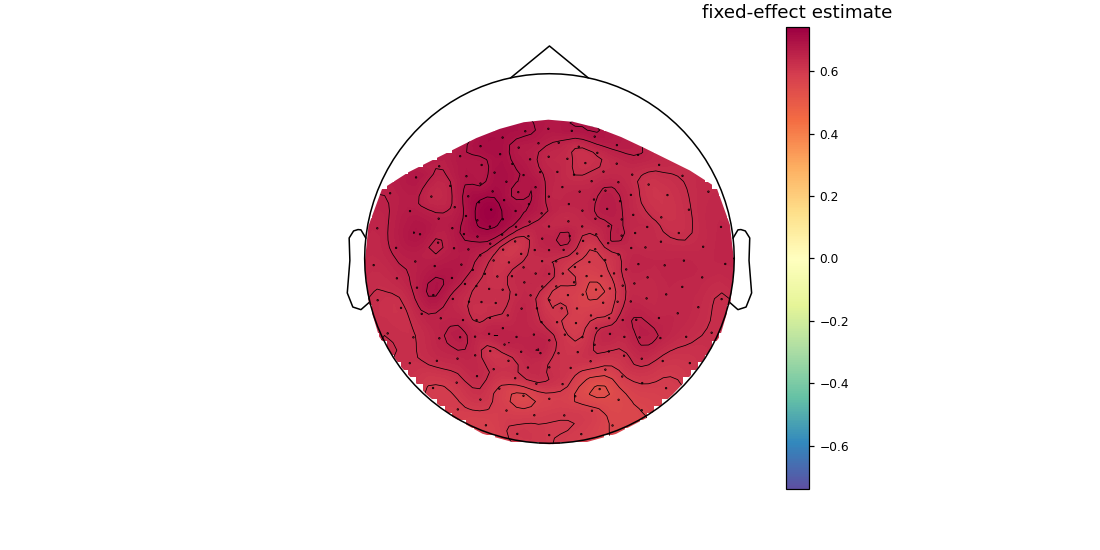

D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run--_fig_GLM_RT_beforedelta.z.jpg


<IPython.core.display.Javascript object>


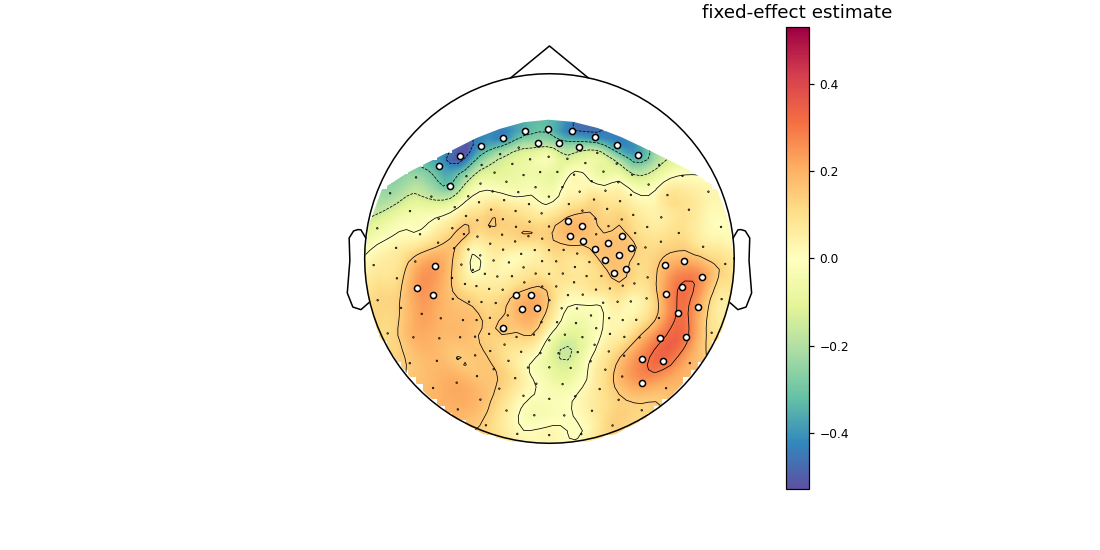

D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run--_fig_GLM_RT_beforetheta.z.jpg


<IPython.core.display.Javascript object>


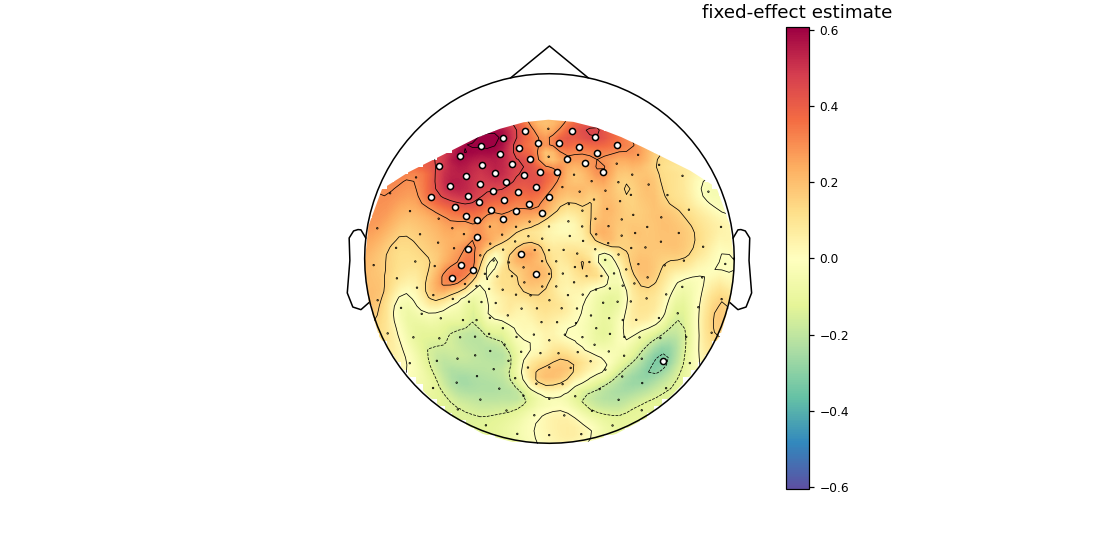

D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run--_fig_GLM_RT_beforealpha.z.jpg


<IPython.core.display.Javascript object>


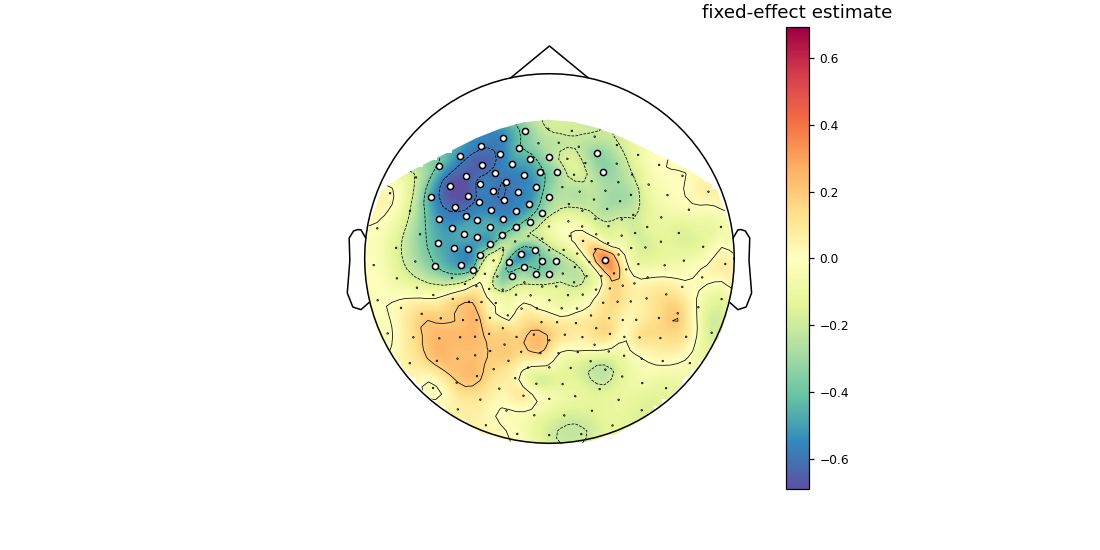

D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run--_fig_GLM_RT_beforelow_beta.z.jpg


<IPython.core.display.Javascript object>


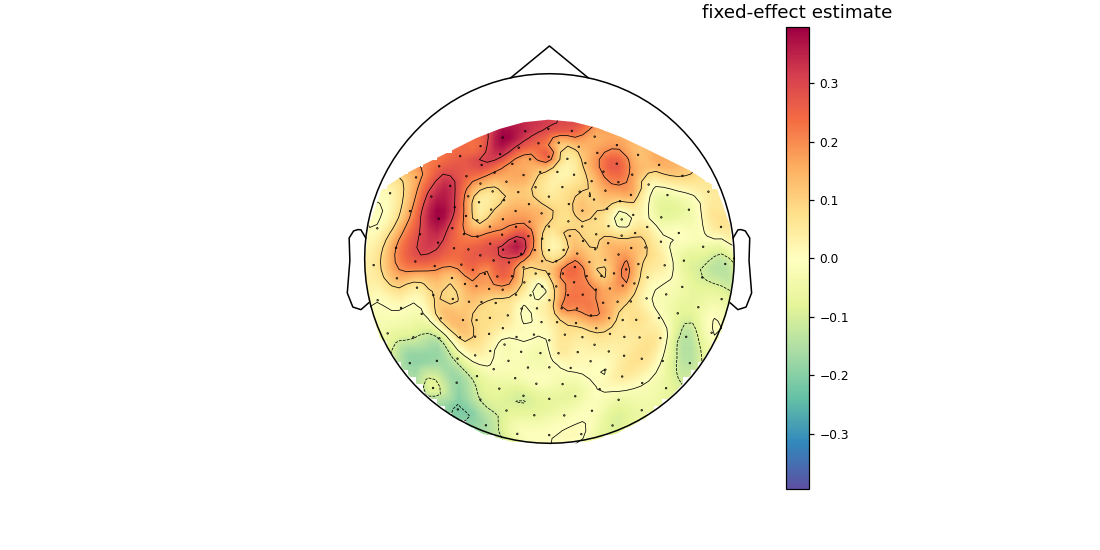

D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run--_fig_GLM_RT_beforehigh_beta.z.jpg


<IPython.core.display.Javascript object>


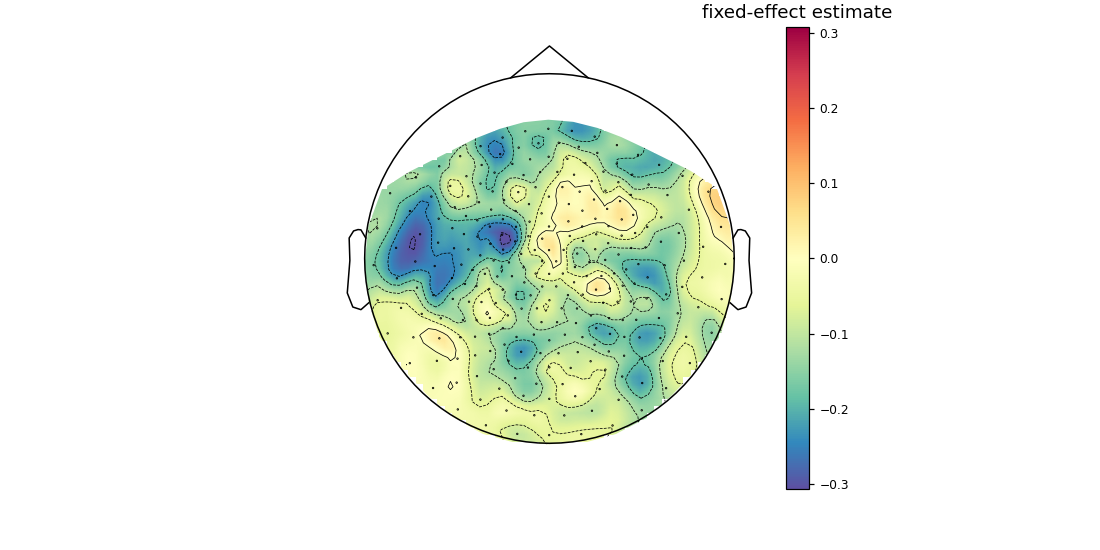

D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run--_fig_GLM_RT_beforegamma1.z.jpg


<IPython.core.display.Javascript object>


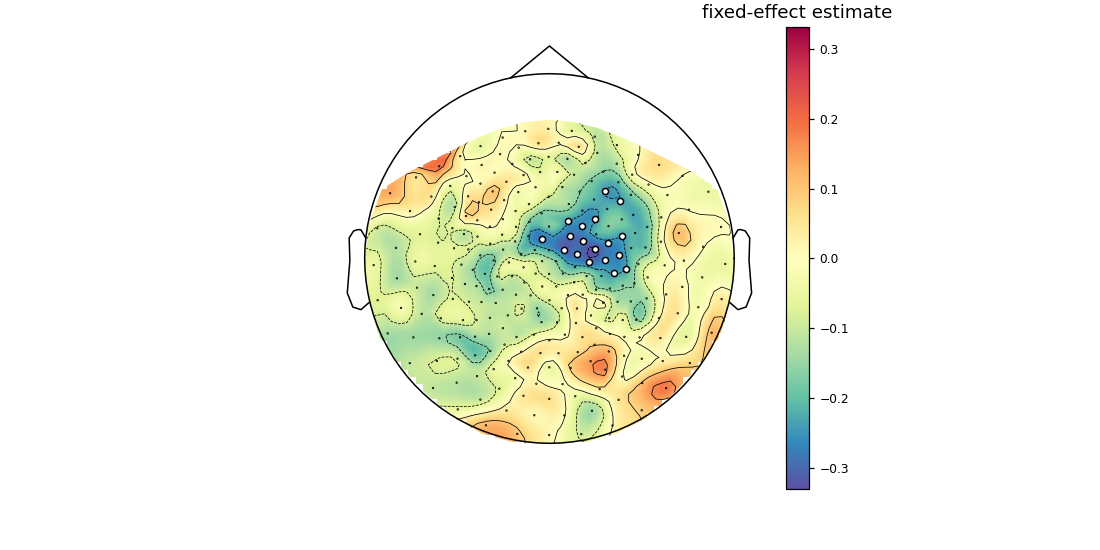

D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run--_fig_GLM_RT_beforegamma2.z.jpg


<IPython.core.display.Javascript object>


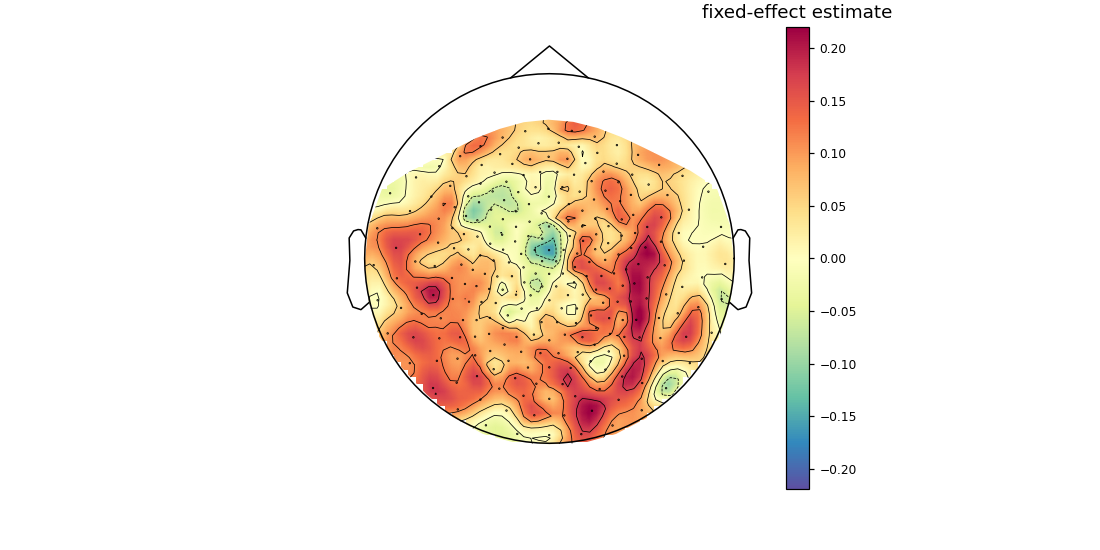

D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run--_fig_GLM_RT_beforeDAT.z.jpg


<IPython.core.display.Javascript object>


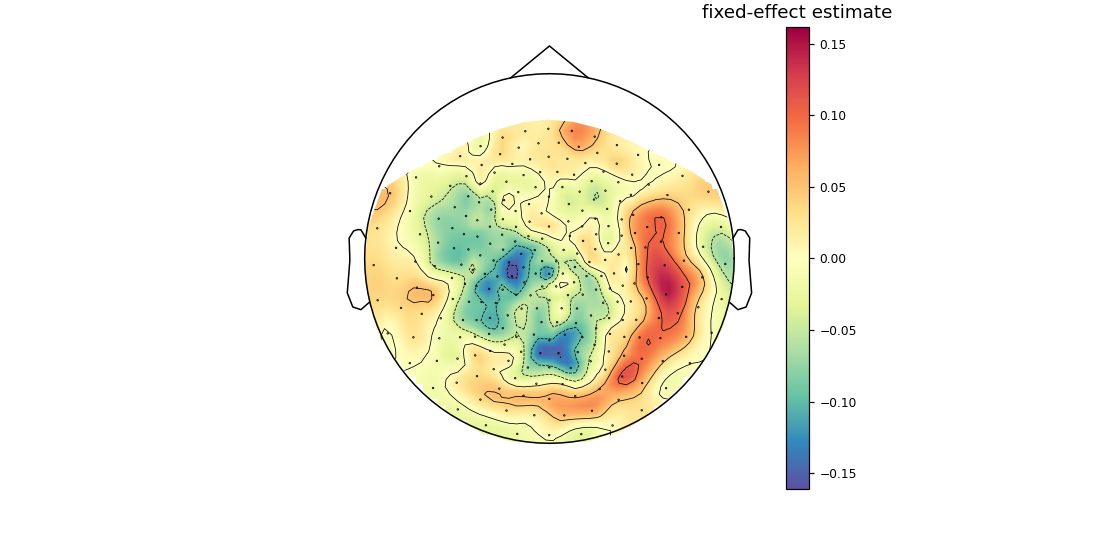

D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run--_fig_GLM_RT_beforeFD.z.jpg


<IPython.core.display.Javascript object>


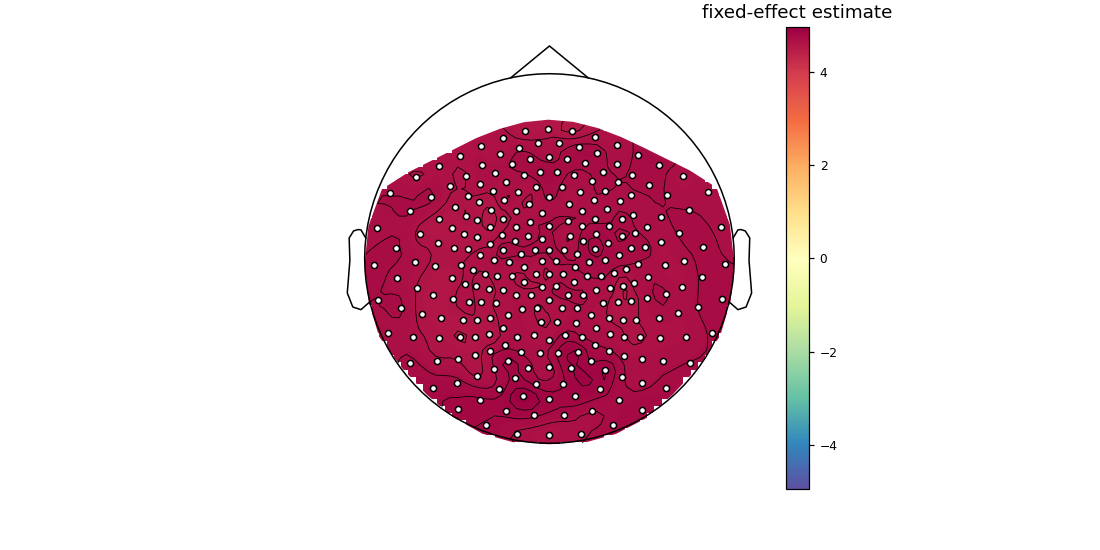

D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run--_fig_GLM_RT_beforeI(FD.z^2).jpg


<IPython.core.display.Javascript object>


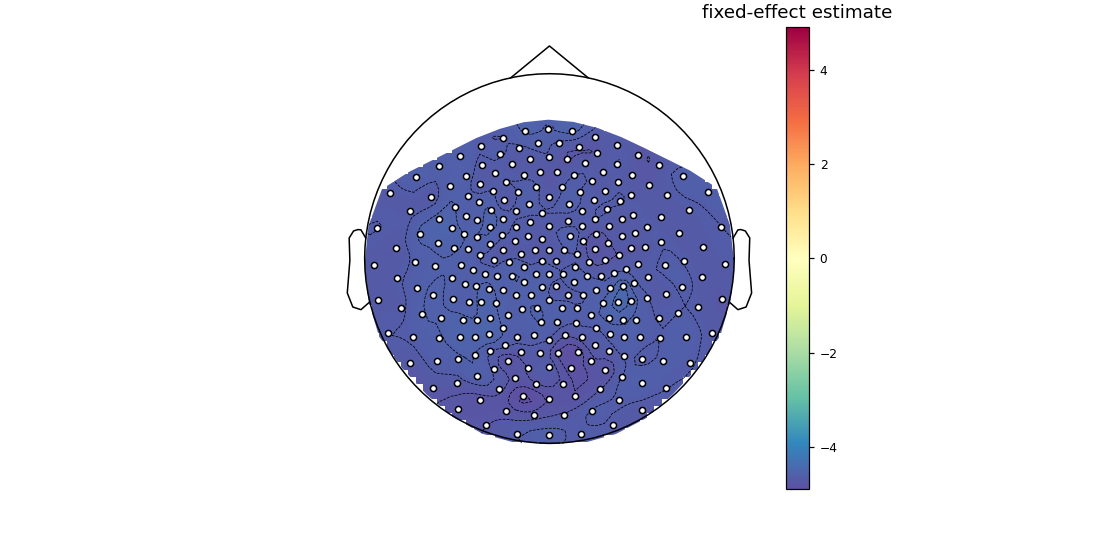

D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run--_fig_GLM_RT_beforedelta.z_by_DAT.z.jpg


<IPython.core.display.Javascript object>


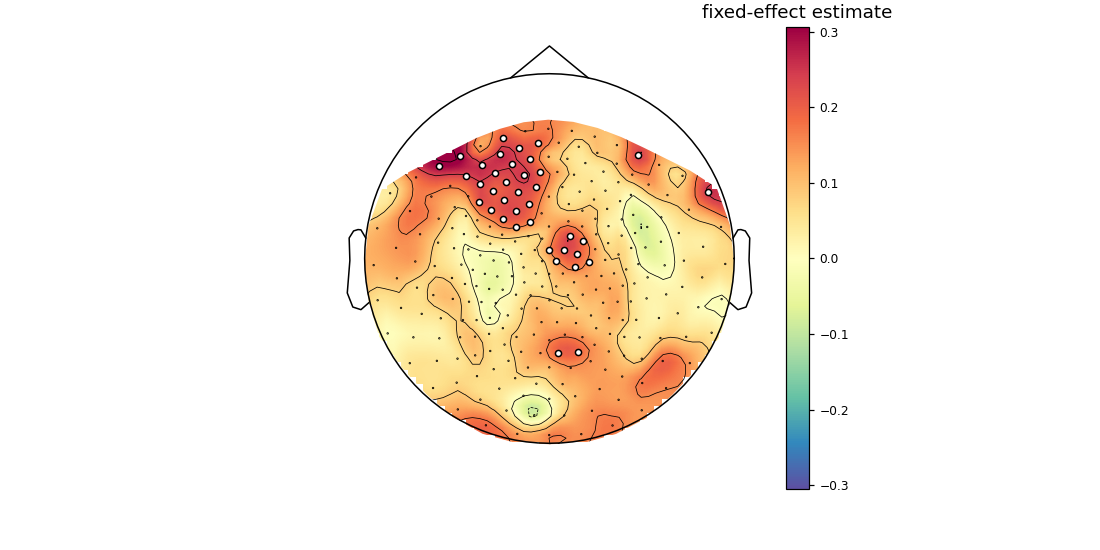

D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run--_fig_GLM_RT_beforetheta.z_by_DAT.z.jpg


<IPython.core.display.Javascript object>


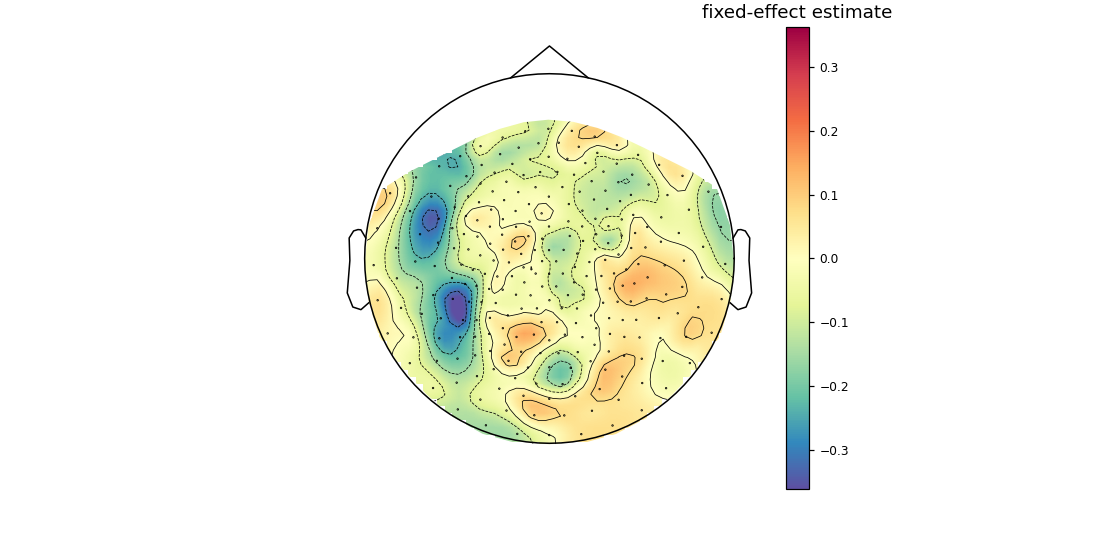

D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run--_fig_GLM_RT_beforealpha.z_by_DAT.z.jpg


<IPython.core.display.Javascript object>


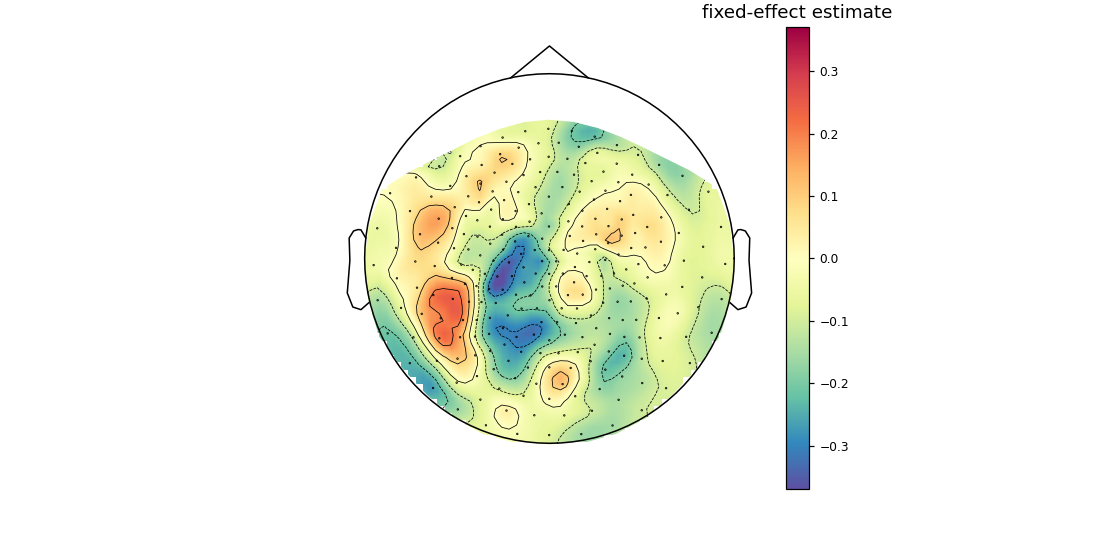

D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run--_fig_GLM_RT_beforelow_beta.z_by_DAT.z.jpg


<IPython.core.display.Javascript object>


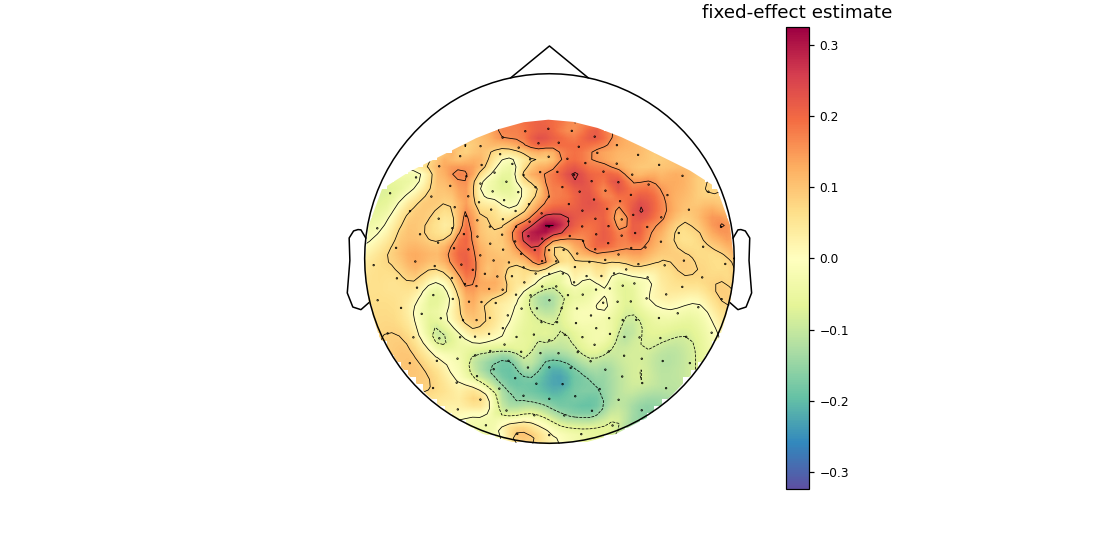

D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run--_fig_GLM_RT_beforehigh_beta.z_by_DAT.z.jpg


<IPython.core.display.Javascript object>


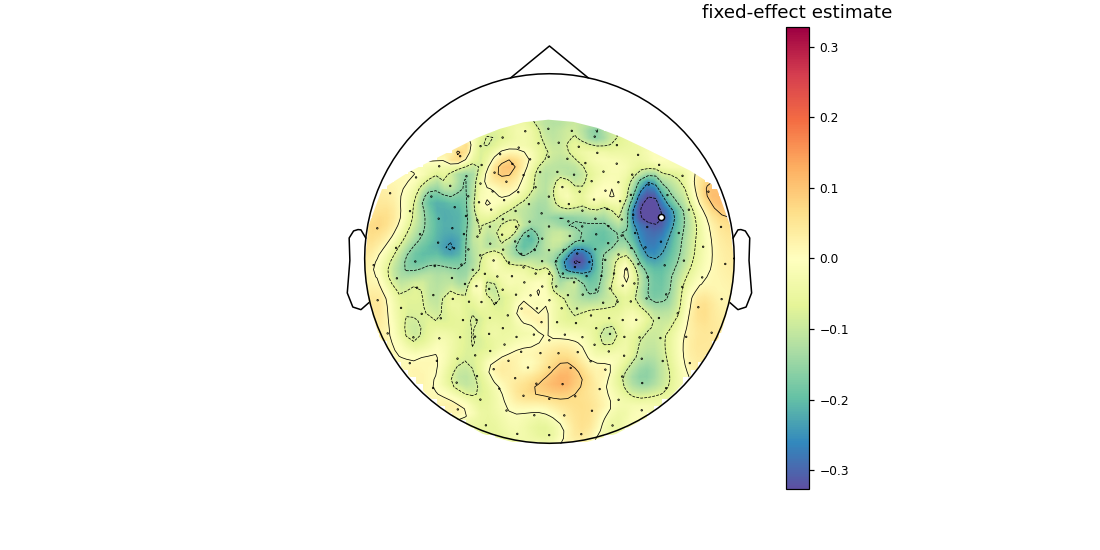

D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run--_fig_GLM_RT_beforegamma1.z_by_DAT.z.jpg


<IPython.core.display.Javascript object>


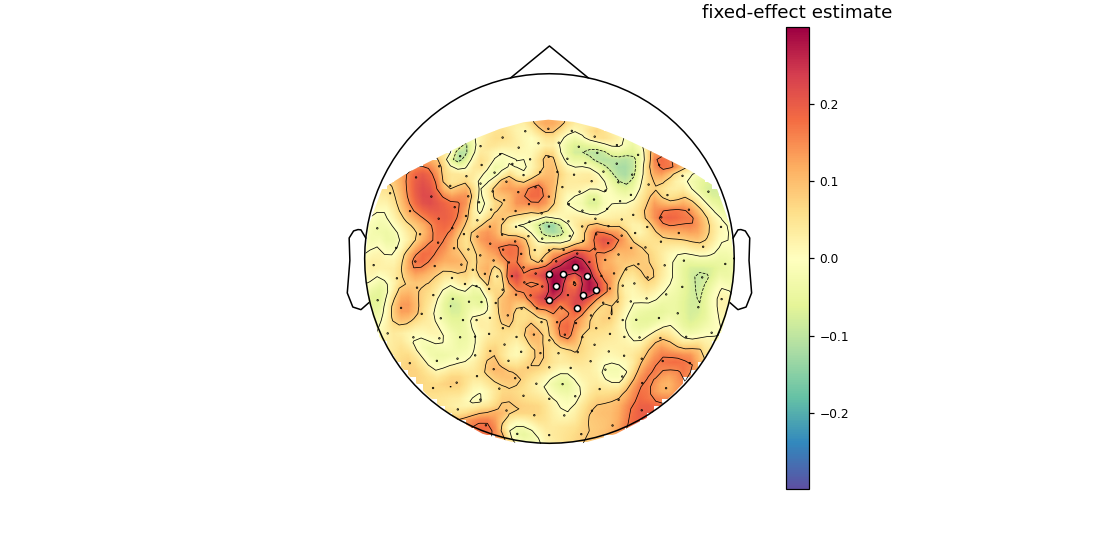

D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run--_fig_GLM_RT_beforegamma2.z_by_DAT.z.jpg


<IPython.core.display.Javascript object>


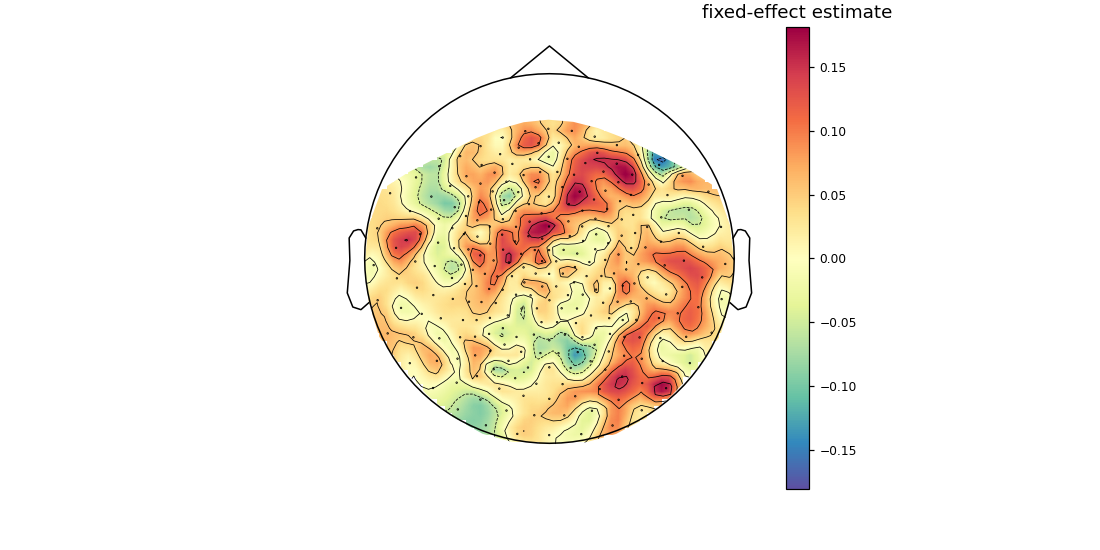

In [151]:
path = 'C:/Users/Antoine/github/MEG_pareidolia/R_data/results/GLM_RT_before'

dict_final = merge_multi_GLM(path, n_electrodes=270, graph=True, ch_xy=ch_xy)

D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run--_fig_GLM_subharm_dist_.jpg


<IPython.core.display.Javascript object>


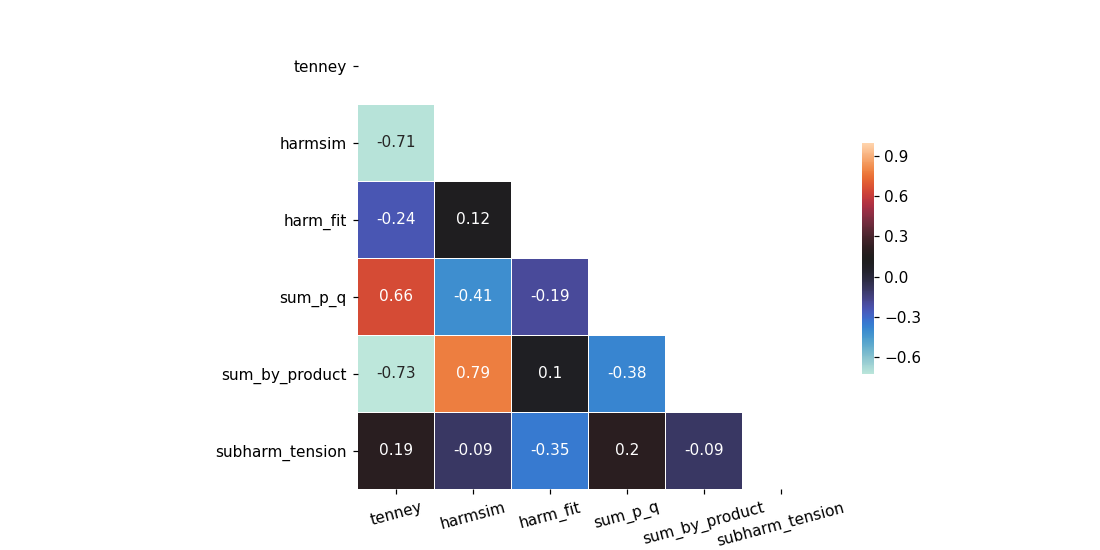

In [85]:
#df_total = pd.read_csv('df_ALL_metadata_MEG_DAT_sub00to11_Complexity_long_AVG.csv')
df_elec = df_total.groupby(by='electrodes').mean()

value_to_plot = df_elec['subharm_tension']
#pvals = dict_final[effect][1]
#_, pvals = fdrcorrection(pvals, alpha=0.05, method='indep')
#mask = p_values_boolean_1d(pvals, threshold = 0.05)
extreme = np.max((abs(np.min(np.min(np.array(value_to_plot)))), abs(np.max(np.max(np.array(value_to_plot)))))) # adjust the range of values
vmax = np.max(np.max(np.array(value_to_plot)))
vmin = np.min(np.min(np.array(value_to_plot)))
reportname, reportpath = get_pareidolia_bids(FOLDERPATH, '00', 'pareidolia', '-', stage = 'fig_GLM_subharm_dist_')
print(reportpath)
#image,_ = mne.viz.plot_topomap(data=value_to_plot, pos=ch_xy, cmap='Spectral_r', vmin=vmin, vmax=vmax, axes=None, show=True, mask = p_welch_multitaper)
fig, ax = topoplot(value_to_plot, ch_xy, vmin=vmin, vmax=vmax, showtitle=True,
                   mask = None, figpath = reportpath, ax_title='subharm tension')

In [ ]:
epochs_name, epochs_path = get_pareidolia_bids(FOLDERPATH, '04', task, '1', stage = 'epo_long', cond=None)
epochs = mne.read_epochs(epochs_path)
    
data = epochs.get_data()

In [ ]:
data.shape

In [ ]:
#Compare models

AICs_rand = []
AICs = []
AICs_int = []
AICs_int_fd_lin = []
AICs_int_mixed = []
AICs_nobj = []
AICs_DAT = []
AICs_DAT_int = []
AICs_multi_int = []
for n in range(0, 270):
    
    AIC_df = pd.read_csv('C:/Users/Antoine/github/MEG_pareidolia/GLM/predict_entropy/GLM_AIC_electrode_'+str(n)+'.csv')
    AICs_rand.append(float(AIC_df['x']))
    
    AIC_df2 = pd.read_csv('C:/Users/Antoine/github/MEG_pareidolia/GLM/predict_entropy_simple_randomstructure/GLM_AIC_electrode_linear_randomeff'+str(n)+'.csv')
    AICs.append(float(AIC_df2['x']))
    
    AIC_df3 = pd.read_csv('C:/Users/Antoine/github/MEG_pareidolia/GLM/predict_ent_int_no_rand/GLM_AIC_electrode_int'+str(n)+'.csv')
    AICs_int.append(float(AIC_df3['x']))
    
    AIC_df4 = pd.read_csv('C:/Users/Antoine/github/MEG_pareidolia/GLM/predict_ent_int_fd_lin/GLM_AIC_electrode_int_lin_fd'+str(n)+'.csv')
    AICs_int_fd_lin.append(float(AIC_df4['x']))
    
    AIC_df5 = pd.read_csv('C:/Users/Antoine/github/MEG_pareidolia/GLM/predict_ent_mixed_struct/GLM_AIC_electrode_int_mixed'+str(n)+'.csv')
    AICs_int_mixed.append(float(AIC_df5['x']))
    
    AIC_df6 = pd.read_csv('C:/Users/Antoine/github/MEG_pareidolia/GLM/predict_ent_n_obj/GLM_AIC_electrode_n_obj'+str(n)+'.csv')
    AICs_nobj.append(float(AIC_df6['x']))
    
    AIC_df7 = pd.read_csv('C:/Users/Antoine/github/MEG_pareidolia/GLM/predict_ent_DAT/GLM_AIC_electrode_n_obj_DAT'+str(n)+'.csv')
    AICs_DAT.append(float(AIC_df7['x']))
    
    AIC_df8 = pd.read_csv('C:/Users/Antoine/github/MEG_pareidolia/GLM/predict_ent_DAT_int/GLM_AIC_electrode_n_obj_DAT_int'+str(n)+'.csv')
    AICs_DAT_int.append(float(AIC_df8['x']))
    
    AIC_df9 = pd.read_csv('C:/Users/Antoine/github/MEG_pareidolia/GLM/predict_ent_multi_int/GLM_AIC_electrode_multi_int'+str(n)+'.csv')
    AICs_multi_int.append(float(AIC_df9['x']))

In [ ]:
np.mean(AICs_int_fd_lin), np.mean(AICs_int_mixed), np.mean(AICs_nobj), np.mean(AICs_DAT), np.mean(AICs_DAT_int), np.mean(AICs_multi_int)

In [ ]:
MEG_atlas = {'CL': list(range(0, 24)), 'FL': list(range(24, 57)), 'OL': list(range(57, 76)), 
             'PL': list(range(76, 97)), 'TL': list(range(97, 131)),
             'CR': list(range(131, 153)), 'FR': list(range(153, 186)), 'OR': list(range(186, 204)), 
             'PR': list(range(204, 226)), 'TR': list(range(226, 259)), 'CZ': list(range(259, 263)),
             'Fz': list(range(263, 266)), 'OZ': list(range(266, 269)), 'PZ': list(range(269, 270))
            }
MEG_regions = list(MEG_atlas.keys())

for r in MEG_regions:
    df = df_total.loc[df_total['region'] == r]
    df.to_csv('12participants_MEG_regions_'+r+'.csv', index=False)

In [ ]:
epochs_path

In [ ]:
df_total = df_total.groupby(by=['region','trials', 'participant']).mean().reset_index()

In [ ]:

epochs_name, epochs_path = get_pareidolia_bids(FOLDERPATH, '01', 'pareidolia', '2', stage = 'epo_RT_post', cond=None)
epochs = mne.read_epochs(epochs_path)
data = epochs.get_data()

In [ ]:
import biotuner
from biotuner.biotuner_utils import *
from biotuner.biotuner_object import *
from biotuner.metrics import *

In [ ]:


data_ = data[1, 10, :]
FREQ_BANDS = [[1, 3], [3, 7], [7, 12], [12, 18], [18, 30], [30, 45]] # Define frequency bands for peaks_function = 'fixed'

biotuning = biotuner(sf = 1000, peaks_function = 'EMD', precision = 0.5, n_harm = 20,
                    ratios_n_harms = 5, ratios_inc_fit = True, ratios_inc = True) # Initialize biotuner object

biotuning.peaks_extraction(data_, FREQ_BANDS = FREQ_BANDS, ratios_extension = True, max_freq = 30, n_peaks=5,
                          graph=True, min_harms=2)
biotuning.compute_peaks_metrics()

tun_metrics = tuning_to_metrics(biotuning.peaks_ratios)
tun_metrics.update(biotuning.peaks_metrics)

In [ ]:
import pandas as pd
#pd.DataFrame.from_dict(tun_metrics, orient='columns', index='0')

df_cons = pd.DataFrame(tun_metrics, index=[0])

In [ ]:
df2 = df_cons.copy()

In [ ]:
a = [df_cons, df2]

In [ ]:
b.to_csv('test.csv', index=False)

In [ ]:
tun_metrics = tuning_to_metrics(biotuning.peaks_ratios)

tun_metrics.update(biotuning.peaks_metrics)
tun_metrics
del tun_metrics["harm_pos"]
del tun_metrics["common_harm_pos"]
tun_metrics

In [ ]:
df_total.loc[df_total['region'] == 'CL']

In [ ]:
df_total.sort_values(by='electrodes')
sbn.distplot(df_total['DiffEn'])
plt.xlim =(0,5)
#sbn.regplot(data=df_total, x='DiffEn', y='FD')

In [ ]:
test = pd.concat([metadata, complexity], axis=0)
test

In [ ]:
#COMPLEXITY MATCHING
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection
from MEG_pareidolia_utils import *

RUN_LIST = {'pareidolia':['1', '2','3','4', '5', '6']}
SUBJ_LIST = ['00', '01', '02', '04', '05', '06', '08', '10', '11']
#SUBJ_LIST = ['05', '06']
TASK_LIST = ['pareidolia']
COMPLEX_LIST = ['Hjorth', 'SVDEn', 'DiffEn', 'KFD', 'PFD', 'RR', 'SFD', 'SpEn']
COMPLEX_LIST = ['PSDslope', 'ApEn', 'WPEn', 'MSE', 'Hurst', 'LZC']
#COMPLEX_LIST = ['DiffEn']
metadata_cond = 'parei == 0'
all_complex = []
pvals_tot = []
rvals_tot = []
for subj in SUBJ_LIST:
    subj_cp = []
    for task in TASK_LIST:
        task_cp = []
        sham_cp = []
        epochs_tot = []
        epo_idxs = []
        for e, run in enumerate(RUN_LIST[task]):
            try:
                cp_name, cp_path = get_pareidolia_bids(FOLDERPATH, subj, task, run, stage = 'Complexity_RT_before', cond=None)
                epo_name, epo_path = get_pareidolia_bids(FOLDERPATH, subj, task, run, stage = 'epo_RT', cond=None)
                epochs = mne.read_epochs(epo_path)
                #epochs.metadata = epochs.metadata.reset_index()
                epochs_data = epochs.get_data()
                epochs_data = epochs_data
                epochs = epochs[metadata_cond]
                epo_idx = list(epochs.metadata.reset_index(drop=True)['FD'].keys())
                complexity = pd.read_csv(cp_path)
                complexity = complexity.rename(columns={"Unnamed: 0": "trials", "Unnamed: 1": "electrodes"})
                complexity = complexity.set_index(['trials', 'electrodes'])  
                epochs_tot.append(epochs)
                epo_idxs.append(epo_idx)
                cp_idx = []
                for i in epo_idx:
                    cp_idx.append(complexity.iloc[complexity.index.get_level_values('trials') == i])
                #print(cp_idx)
                complexity = pd.concat((cp_idx))
                if e < 6:
                    task_cp.append(complexity)
                else:
                    sham_cp = complexity
            except FileNotFoundError:
                pass
                
        pvals_comp = []
        rvals_comp = []
        for complex_name in COMPLEX_LIST:
            FD_list = []
            complex_list = []
            #Split by conditions for each of the 3 first blocs (task_PSD)
            for i in range(len(task_cp)): 
                FD_list.append(epochs_tot[i].metadata['FD'])
                complex_list.append(task_cp[i][complex_name])
                
            FD_list = np.concatenate(FD_list)
            
            corr_values = []
            p_values = []
            for elec in range(len(task_cp[0][complex_name][epo_idxs[0][0]])):
                complex_list_elec = []
                for i in range(len(complex_list)):
                    complex_list_elec.append(complex_list[i][:, elec])
                complex_list_elec = np.concatenate(complex_list_elec)
                print(len(FD_list), len(complex_list_elec))
                r_value, p_val = pearsonr(list(FD_list), list(complex_list_elec))
                ##PERMUTATIONS
                #Initialize variables:
                pR = []
                #Choose number of permutations:
                p=1000
                FD_list_copy = copy.copy(list(FD_list))
                #Initialize permutation loop:
                for i in range(0,p):
                  #Shuffle one of the features:
                    random.shuffle(FD_list_copy)
                    #Computed permuted correlations and store them in pR:
                    pR.append(stats.pearsonr(FD_list_copy,list(complex_list_elec))[0])

                #Significance:
                p_val = len(np.where(np.abs(pR)>=np.abs(r_value))[0])/p
                corr_values.append(r_value)
                p_values.append(p_val)
                
            pvals_comp.append(p_values)
            rvals_comp.append(corr_values)
            #_, p_values = fdrcorrection(p_values, alpha=0.05, method='indep')           
            #Determine the channels to use in the topomap
            epo_name, epo_path = get_pareidolia_bids(FOLDERPATH, subj, 'pareidolia', '2', stage = 'epo_RT', cond=None)
            epochs = mne.read_epochs(epo_path)
            ch_xy = epochs.pick_types(meg=True, ref_meg=False).info
            
            mask = p_values_boolean_1d(p_values)
            print(mask)

            value_to_plot = corr_values #t-values are plotted
            extreme = np.max((abs(np.min(np.min(np.array(value_to_plot)))), abs(np.max(np.max(np.array(value_to_plot)))))) # adjust the range of values
            vmax = extreme
            vmin = -extreme
            reportname, reportpath = get_pareidolia_bids(FOLDERPATH, subj, 'pareidolia', '-', stage = 'fig_comp_corr_RT_perm_test_NOparei_'+complex_name)

            #image,_ = mne.viz.plot_topomap(data=value_to_plot, pos=ch_xy, cmap='Spectral_r', vmin=vmin, vmax=vmax, axes=None, show=True, mask = p_welch_multitaper)
            fig, ax = topoplot(value_to_plot, ch_xy, vmin=vmin, vmax=vmax, showtitle=True, titles=complex_name, mask = mask, figpath = reportpath, ax_title='pearson r');
    pvals_tot.append(pvals_comp)
    rvals_tot.append(rvals_comp)

for e, c in enumerate(COMPLEX_LIST):
    rvals = np.array(rvals_tot)[:, e, :]
    pvals = np.array(pvals_tot)[:, e, :]
    pvals_final = np.average(pvals, axis=0)
    rvals_final = np.average(rvals, axis=0)
    #_, pvals_final = fdrcorrection(pvals_final, alpha=0.05, method='indep') 
    p_boolean = p_values_boolean_1d(pvals_final)
    #Low values indicate that the first element of t-test is lower than the second element
    value_to_plot = rvals_final #t-values are plotted
    extreme = np.max((abs(np.min(np.min(np.array(value_to_plot)))), abs(np.max(np.max(np.array(value_to_plot)))))) # adjust the range of values
    vmax = extreme
    vmin = -extreme
    reportname, reportpath = get_pareidolia_bids(FOLDERPATH, '11', 'pareidolia', '-', stage = 'fig_comp_corr_RT_perm_test_NOparei_AVG_'+str(c))
    fig, ax = topoplot(value_to_plot, ch_xy, vmin=vmin, vmax=vmax, showtitle=True, titles=c, mask = p_boolean, figpath = reportpath)

In [ ]:
complexity

In [ ]:
a = 'a'
b = 'b'
a+b


In [ ]:
events[0:4]

In [ ]:
new_metadata = pd.DataFrame(
                            index=range(52))
len(new_metadata)

In [ ]:
idxs = [1, 4, 6]
a = task_cp[0].iloc[task_cp[0].index.get_level_values('trials') == 9]
b = task_cp[0].iloc[task_cp[0].index.get_level_values('trials') == 12]
test = [a, b]
c = pd.concat((test))
c

In [ ]:
epo_name, epo_path = get_pareidolia_bids(FOLDERPATH, '02', 'pareidolia', '8', stage = 'epo_long_n_objects', cond=None)
epochs = mne.read_epochs(epo_path)


In [ ]:
epochs.metadata
#epochs['earlyVSlate== 1']

In [ ]:
RUN_LIST = {'pareidolia':['1', '2', '3', '4', '5', '6', '7', '8']}
SUBJ_LIST = ['00', '01', '02']
TASK_LIST = ['pareidolia']
window = None
n_objects = 'binary' # can equate to 'all' if we want precise values instead of one vs many
slowVSfast = False

## 'Window = None' when you want epochs for the full trial size (8sec), 'window = 'RT'' when you want epochs around the response event
epochs, FDlist, n_objects_list, events = epoching('00', 'pareidolia', '1', slowVSfast = slowVSfast, FD = 'class', window = window, n_objects=n_objects)
#In this line, the 'stage' value needs to begin with 'epo', and then you can add anything at the end to identify which epochs
#have been created. This will represent the end of the name of the epoched file.
#epochs_file, epochs_path = get_pareidolia_bids(FOLDERPATH, subj, task, run_str, stage = 'epo_long_n_objects')
#epochs.save(epochs_path, overwrite=True)

len(epochs.events), len(FDlist)

In [ ]:
epochs.metadata = new_metadata

In [ ]:
event_id = {'Image_on_nopar': 4, 'Image_on_par': 44}


def earlyVSlate (events, RT_thresh):
    earlyVSlate_vec = []
    i=0
    for e in range(len(events[:, 2])):
        #Late
        if (events[e][2] == 44 and events[e+1][2] == 6 and ((events[e+2][0])-(events[e+1][0]))<=RT_thresh):
            earlyVSlate_vec.append('late')
        #Early
        if (events[e][2] == 44 and events[e+1][2] == 6 and ((events[e+2][0])-(events[e+1][0]))>RT_thresh):
            earlyVSlate_vec.append('early')
        #None
        if events[e][2] == 44 and events[e+1][2] != 6:
            earlyVSlate_vec.append('None')
        if events[e][2] == 4:
            earlyVSlate_vec.append('None')
    return earlyVSlate_vec

In [ ]:
EL_vec = earlyVSlate(events, 4000)

In [ ]:
behav_name, behav_path = get_pareidolia_bids(FOLDERPATH, '02', 'pareidolia', '1', stage = 'behav')
behav = pd.read_csv(behav_path)
behav = arrange_dataframe(behav)

behav = behav.loc[behav['bloc'] == 4]
behav['positive_n_objets']

n_objects_list = list(np.array(behav['positive_n_objets']))


In [ ]:
a = 4
b = 5
if a==4 and b==5:
    print('hello')

In [ ]:


folderpath = 'D:/PsychoPy_MEG/acquisitions/20210330/P00_PAREMEG-abellemare_20210330_07.ds'
#savepath = folderpath + 'saflow_preproc/'
#subfolder = "20190807/"
#filepath = folderpath + subfolder

#filename = 'P00_PAREMEG-abellemare_20210330_02'
#filepath = folderpath + '\\' + filename

raw_data = read_raw_ctf(filepath, preload=True)

In [ ]:
raw_data.info.get('ch_names')

In [ ]:
mne.find_events(raw_data, shortest_event = 1)

In [ ]:
folderpath[-5:-3]

In [ ]:
picks = mne.pick_types(raw_data.info, meg=True, eog=True, exclude='bads')
#raw_data.plot();
#raw_data.plot_psd(average=False, picks=picks)

In [ ]:

##Remplacer le path de cette variable
FOLDERPATH = r'D:\PsychoPy_MEG\BIDS_data'
##Ne pas inclure 'RS' si vous ne voulez pas faire le processing des blocs Resting State
RUN_LIST = {'pareidolia':['1']}

              #,'RS':['1', '2']}
##Choisir le ou les participants à processer.
SUBJ_LIST = ['00']
TASK_LIST = ['pareidolia']

#for subj, ecg, eog in zip(SUBJ_LIST, ECG_DICT, EOG_DICT):
for subj in SUBJ_LIST:
    for task in TASK_LIST:
        for run in RUN_LIST[task]:
            filename, filepath = get_pareidolia_bids(FOLDERPATH, subj, task, run, stage = 'meg', cond=None)
            preproc_name, preproc_path = get_pareidolia_bids(FOLDERPATH, subj, task, run, stage = 'preproc', cond=None)
            report_name, report_path = get_pareidolia_bids(FOLDERPATH, subj, task, run, stage = 'report_preproc', cond=None)

            #pareidolia_preproc(filepath, preproc_path, report_path)


In [ ]:
from MEG_pareidolia_utils import arrange_dataframe
behav_name, behav_path = get_pareidolia_bids(FOLDERPATH, '00', 'pareidolia', '1', stage = 'behav')
behav = pd.read_csv(behav_path)
behav = arrange_dataframe(behav)

In [ ]:
FDlist = list(np.array(behav['FD']))
FDlist

In [ ]:
preproc_name, preproc_path = get_pareidolia_bids(FOLDERPATH, '01', 'pareidolia', '1', stage = 'preproc')
preproc = read_raw_fif(preproc_path, preload=True)
events = mne.find_events(preproc, shortest_event = 1) 

In [ ]:
behav = behav.loc[behav['bloc'] == 1]
FDlist = list(np.array(behav['FD']))

In [ ]:
def reformat_events (events, FDlist, RT_thresh = 4000, task = 'pareidolia', run = None, slowVSfast = False, FD = 'class'):

    if task == 'pareidolia':
        ##Rename Image onset events to inform about pareidolia and FDx`
        i = -1
        RT = []
        if FD == 'all':
            for z in range(len(FDlist)):
                print(FDlist[z])
                FDlist[z] = int(FDlist[z]*10)
                #print(FDlist[z])
        for e in range(len(events)):
            if (events[e][2] == 4 and events[e+1][2] == 6):
                RT.append(events[e+1][0]-events[e][0])

        medianRT = np.median(RT)
        print(medianRT)
        
        for e in range(len(events)):

            if slowVSfast == True:
                #Late
                if (events[e][2] == 4 and events[e+1][2] == 6 and ((events[e+2][0])-(events[e+1][0]))<=RT_thresh):
                    events[e][2] = 444
                #Early
                if (events[e][2] == 4 and events[e+1][2] == 6 and ((events[e+2][0])-(events[e+1][0]))>RT_thresh):
                    events[e][2] = 44
                # Set FD
                if FD == 'all':
                    if (events[e][2] == 4 or events[e][2] == 44 or events[e][2] == 444):
                        i = i+1
                        events[e][2] = int(str(events[e][2]) + str(FDlist[i]))
                if FD == 'class':
                    FDclass = FD2FDclass(FDlist)
                    #print(len(FDclass))
                    #print(FDclass)
                    if (events[e][2] == 7 or events[e][2] == 77 or events[e][2] == 777):
                        i = i+1
                        print(i)
                        events[e][2] = int(str(events[e][2]) + str(FDclass[i]))
                        #print(events[e][2])


                    if (events[e][2] == 4 and ((events[e+1][0])-(events[e][0]))<=RT_thresh):
                        events[e][2] = int('44'+str(FDclass[i]))
                    if (events[e][2] == 4 and ((events[e+1][0])-(events[e][0]))>RT_thresh):
                        events[e][2] = int('4'+str(FDclass[i]))
            if slowVSfast == False:
                if (events[e][2] == 4 and events[e+1][2] == 6):
                    events[e][2] = 44
                if FD == 'all':
                    if (events[e][2] == 7 or events[e][2] == 77):
                        i = i+1
                        events[e][2] = int(str(events[e][2]) + str(FDlist[i]))
                if FD == 'class':
                    FDclass = FD2FDclass(FDlist)
                    #print(FDclass)
                    if (events[e][2] == 4 or events[e][2] == 44):
                        i = i+1
                        events[e][2] = int(str(events[e][2]) + str(FDclass[i]))
                    if events[e][2] == 4:
                        events[e][2] = int('4'+str(FDclass[i]))
                    if events[e][2] == 44:
                        events[e][2] = int('44'+str(FDclass[i]))
        '''for e in range(len(events)):
            if (events[e][2] == 7 or events[e][2] == 70 or events[e][2] == 71 or events[e][2] == 72):# and events[e+1][2] != 4):
                print('found_new')
                new_timing = events[e][0] + medianRT
                events = np.insert(events, e+1, np.array((new_timing, 0, 55)), 0)'''
    if task == 'RS':
        if run == '1':
            events[:, 2] = np.where(events[:, 2]==1, 100, events[:, 2])
            events[:, 2] = np.where(events[:, 2]==2, 101, events[:, 2])
        if run == '2':
            events[:, 2] = np.where(events[:, 2]==1, 200, events[:, 2])
            events[:, 2] = np.where(events[:, 2]==2, 201, events[:, 2])

    return events, medianRT

In [ ]:
events, medianRT = reformat_events(events, FDlist, 4000, 'pareidolia', '1', slowVSfast=False, FD='class')

In [ ]:
events

In [ ]:
event_id = {'Image_on_nopar_low': 40, 'Image_on_par_low': 440,
                    'Image_on_nopar_mid': 41, 'Image_on_par_mid': 441,
                    'Image_on_nopar_high': 42, 'Image_on_par_high': 442}

In [ ]:
events

In [ ]:
def remove_absent_event_ids (events, event_id):
    events = events[:, 2]
    print(events)
    keys2remove = []
    for e, key in zip(event_id.values(), event_id.keys()):
        if e not in events:
            print(e)
            keys2remove.append(key)
    
    for k in keys2remove:
        del event_id[k]
    
    return event_id

In [ ]:
event_id2 = remove_absent_event_ids(events, event_id)
event_id2

In [ ]:
from mne_bids import BIDSPath
BIDS_PATH = r'D:\PsychoPy_MEG\BIDS_data'
bidspath = BIDSPath(subject='00', session='recording', task='pareidolia', run='1', suffix='meg', extension='.ds', root=BIDS_PATH)

In [ ]:
9361/1200

In [ ]:
epochs_name, epochs_path = get_pareidolia_bids(FOLDERPATH, '01', 'pareidolia', '6', stage = 'epo_long_meta', cond=None)
epochs = mne.read_epochs(epochs_path)
epochs

In [ ]:
epochs['earlyVSlate== 1' and 'parei== 0']
epochs.metadata
CONDITIONS_LIST = [['contrast== 1' and 'parei== 0','contrast== 1' and 'parei== 1'], ['contrast== 0' and 'parei== 0','contrast== 0' and 'parei== 1']]
CONDITIONS_LIST = ['contrast== 1' and 'parei== 0','contrast== 1' and 'parei== 1']
CONDITIONS_LIST[0]

In [ ]:
layout = mne.channels.find_layout(epochs['Image_on_par_mid'].info, ch_type='meg')
layout.pos.shape
layout2 = np.swapaxes(layout.pos, 0, 1)

In [ ]:
ch_xy = epochs.pick_types(meg=True, ref_meg=False).info

In [ ]:
ch_xy

In [ ]:
layout2[0:2].shape

In [ ]:
picks = mne.pick_types(epochs.info, meg=True, ref_meg=False, eeg=False, eog=False, stim=False)
picks.shape

In [ ]:
picks = mne.pick_types(epochs.info, meg=True, ref_meg=False, eeg=False, eog=False, stim=False)
picks.shape

In [ ]:
epochs['contrast== 0']

In [ ]:
PSD_name, PSD_path = get_pareidolia_bids(FOLDERPATH, '01', 'pareidolia', '3', stage = 'PSD_long_meta', cond=None)
epo_name, epo_path = get_pareidolia_bids(FOLDERPATH, '01', 'pareidolia', '3', stage = 'epo_long_meta', cond=None)
PSD = loadmat(PSD_path)
PSD = PSD['PSD']
epochs = mne.read_epochs(epo_path)
epochs

evokeds = dict()
query = 'earlyVSlate== {}'

epochs2 = epochs.copy().crop(tmin=0.5, tmax=1)
for n_letters in epochs2.metadata['earlyVSlate'].unique():
    print(query.format(n_letters))
    evokeds[str(n_letters)] = epochs2[query.format(n_letters)].average()

mne.viz.plot_compare_evokeds(evokeds, cmap=('earlyVSlate', 'viridis'),
                             picks=68)

In [ ]:
epochs['FD_class== 2']

In [ ]:
epochs.metadata

In [ ]:
epochs[:][conditions[1]]

In [ ]:

conditions = ['earlyVSlate== 1', 'earlyVSlate== 2']



def split_by_2_conditions (psd, epochs, conditions): 
    
    c1_idx = []
    c2_idx = []
    for i, e in enumerate(epochs):
        if len(epochs[i][conditions[0]]) != 0:
            c1_idx.append(i)
        if len(epochs[i][conditions[1]]) != 0:
            c2_idx.append(i)        
    cond1 = []
    cond2 = []
    for i1 in c1_idx:
        cond1.append(psd[i1])
    for i2 in c2_idx:
        cond2.append(psd[i2])
    
    return np.array(cond1), np.array(cond2)

#c1, c2 = split_by_condition(data, epochs, a, b, condition = None, epochs_type = None)

In [ ]:
conditions = ['n_obj_class== 0', ['n_obj_class== 2']]
cond1, cond2 = split_by_2_conditions(PSD, epochs, conditions)
cond1.shape, cond2.shape

In [ ]:
PSD_name, PSD_path = get_pareidolia_bids(FOLDERPATH, '00', 'pareidolia', '5', stage = 'PSD_long_AR_pnp', cond=None)
PSD = loadmat(PSD_path)

In [ ]:
task_PSD, sham_PSD, epochs_tot = taskVSsham('01', 'PSD_long_AR_pnp', 'epo_long_AR_pnp', FOLDERPATH)

In [ ]:
events, medianRT = reformat_events(events, FDlist, RT_thresh, task, run, slowVSfast=False, FD='class')

In [ ]:
cond1, cond2= split_by_condition(task_PSD[3], epochs_tot['4'], a=40, b=440, condition = None, epochs_type = 'Long')

In [ ]:
behav_name, behav_path = get_pareidolia_bids(FOLDERPATH, subj, task, '1', stage = 'behav')
behav = pd.read_csv(behav_path)
behav = arrange_dataframe(behav)

behav = behav.loc[behav['bloc'] == 1]

In [ ]:
#If RT =! NaN and positive_n_objts == 0:
    #events[:, 2] = 4
    #del(events[:, 2]+1)
#If RT == NaN and positive_n_objets > 0:
    #events[:, 2] = 44
behav

In [ ]:
task_PSD, sham_PSD, epochs_tot = taskVSsham('01', 'PSD_long_AR_pnp','epo_long_AR_pnp' , FOLDERPATH)

In [ ]:
task_PSD[2].shape

In [ ]:
cond1_tot = []
cond2_tot = []
#Split by conditions for each of the experimental blocs (task_PSD)
for i in range(len(task_PSD)):
    epochs_id = str(i+1)
    print(i)
    cond1, cond2= split_by_condition(task_PSD[i], epochs_tot[epochs_id], a=c[0], b=c[1], condition = c, epochs_type = 'Long') #epochs_type could be 'Long' or 'RT'
    cond1_tot.append(cond1)
    cond2_tot.append(cond2)
cond1_tot = np.array(cond1_tot)
cond2_tot = np.array(cond2_tot)
all_blocs1 = np.append(cond1_tot[0], cond1_tot[1], axis = 0)
all_blocs1 = np.append(all_blocs1, cond1_tot[2], axis = 0)
all_blocs2 = np.append(cond2_tot[0], cond2_tot[1], axis = 0)
all_blocs2 = np.append(all_blocs2, cond2_tot[2], axis = 0)
try:
    sham1, sham2 = split_by_condition(sham_PSD, epochs_tot['4'], c[0], c[1], condition = None)
except:
    pass

In [ ]:
epochs[3]['earlyVSlate== 0']['parei==0']

In [ ]:
#complexity_eeg = nk.complexity(epochs.get_data()[10, 100, 1000:6000], sampling_rate=epochs.info['sfreq'],
#                                            shannon=False, sampen=False, multiscale=False, spectral=False, svd=True,
#                                            correlation=False, higushi=False, petrosian=False, fisher=False, hurst=False,
#                                             dfa=False, lyap_r=False, lyap_e=False, bands=[7, 12])


#complexity_eeg.shape

In [ ]:
results, info = nk.complexity(epochs.get_data()[12, 100, 1000:6000], which=['fast', 'medium'])

In [ ]:
final2 = pd.DataFrame()
final2 = final2.append(results2)
final2 = final2.append(results)

In [ ]:
final = pd.DataFrame()
final = final.append(results2)
final = final.append(results)
final

In [ ]:
test = pd.concat([final.reset_index(), final2.reset_index()], keys=range(2))
test.to_csv('test.csv', index=True)

In [ ]:
load = pd.read_csv('test.csv', index_col=[0, 1])
load

In [ ]:
epochs.get_data()[10, 100, 1000:6000].shape

In [ ]:
complexity_eeg[0]

In [ ]:
from MEG_pareidolia_utils import *
import mne # Here we import mne, the package that will contain most of the function that we will use today.
from mne.datasets.brainstorm import bst_raw # It is possible to import functions individually. This is helpful since it
                                            # saves time, memory, and makes the calls to the function easier.
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
import time
import numpy as np
import scipy.io as sio
from scipy.io import savemat, loadmat
import nolds
import neurokit2 as nk
from scipy import stats
import matplotlib.pyplot as plt
from PARAMS import *


RUN_LIST = {'pareidolia':['1']}
SUBJ_LIST = ['01']
TASK_LIST = ['pareidolia']
which_complex = ['fast']#, 'medium']

##Compute complexity
#https://github.com/neuropsychology/NeuroKit/blob/master/neurokit2/complexity/complexity.py

for subj in SUBJ_LIST:
    for task in TASK_LIST:
        for run in RUN_LIST[task]:
            epochs_name, epochs_path = get_pareidolia_bids(FOLDERPATH, subj, task, run, stage = 'epo_long_meta', cond=None)
            epochs = mne.read_epochs(epochs_path)
            epochs_data = epochs.get_data()
            complex_tot = []
            for i in range(5):
                complex_trials = pd.DataFrame()
                for j in range(8):
                    results, info = nk.complexity(epochs_data[i][j], which=which_complex)
                    print(results)
                    complex_trials.append(results)
                complex_tot.append(complex_trials.reset_index())
                
            complex_final = pd.concat(complex_tot, keys=range(len(epochs_data)))
            complex_file, complex_path = get_pareidolia_bids(FOLDERPATH, subj, task, run, stage = 'Complexity')
            #complex_tot.to_csv(complex_path, index=True)

In [ ]:
#complex_trials = pd.DataFrame()
results, info = nk.complexity(epochs_data[1][1], which=which_complex)
print(results)
complex_trials = complex_trials.append(results)
complex_trials

In [ ]:
complex_file, complex_path = get_pareidolia_bids(FOLDERPATH, '00', 'pareidolia', '4', stage = 'Complexity')
complexity = pd.read_csv(complex_path)
complexity = complexity.rename(columns={"Unnamed: 0": "trials", "Unnamed: 1": "electrodes"})
complexity = complexity.set_index(['trials', 'electrodes'])

complexity.loc[2]

### Reaction Time Distribution

In [ ]:
import mne # Here we import mne, the package that will contain most of the function that we will use today.
from mne.datasets.brainstorm import bst_raw # It is possible to import functions individually. This is helpful since it
                                            # saves time, memory, and makes the calls to the function easier.
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from autoreject import AutoReject
from MEG_pareidolia_utils import *
from mne.io import read_raw_fif
import PARAMS
from PARAMS import *

#Here you need to put the same FOLDERPATH as in the preprocessing script

#This variable determines which pareidolia trials will be judged as 'early' or 'late'

#Here you choose which runs and subjects you want to epoch
RUN_LIST = {'pareidolia':['1', '2', '3', '4', '5', '6', '7', '8']}
SUBJ_LIST = ['02']
TASK_LIST = ['pareidolia']
window = None

##EPOCHING
##This is the main EPOCHING function, which takes as input the subject, task, run, as well as a boolean value whether to include information about
##early vs late pareidolia (slowVSfast = True or False) and whether to include fractal
def epoching(subj, task, run, window = None, RT_thresh=5000):
    preproc_name, preproc_path = get_pareidolia_bids(FOLDERPATH, subj, task, run, stage = 'preproc')
    preproc = read_raw_fif(preproc_path, preload=True)
    events = mne.find_events(preproc, shortest_event = 1) 
    ##Get Fractal dimension info from behavioral data
    if task == 'pareidolia':
        behav_name, behav_path = get_pareidolia_bids(FOLDERPATH, subj, task, '1', stage = 'behav')
        behav = pd.read_csv(behav_path)
        behav = arrange_dataframe(behav)
        
        behav = behav.loc[behav['bloc'] == int(run)]
        #print(behav)
        FDlist = list(np.array(behav['FD']))
        n_objects_list = list(np.array(behav['positive_n_objets']))
        n_objects_list = np.nan_to_num(n_objects_list)
        n_obj_class = n_obj2class(n_objects_list)
        parei = [1 if x==2 else x for x in n_obj_class]
    if task == 'RS':
        FDlist = None

    #This line uses the function 'reformat_events', which you can find in EEG_pareidolia_utils, to add information about FD and slowVSfast paeidolia in the
    #event ids.
    events, medianRT, RT = reformat_events_meta(events, FDlist=FDlist, RT_thresh=RT_thresh, task=task, run=run, 
                                       n_objects_list=n_objects_list)
    earlyVSlate_vec = earlyVSlate(events, RT_thresh)
    
    # Creates the metadata DataFrame
    
    new_metadata = pd.DataFrame(
                            index=range(len(FDlist)))
    new_metadata['FD'] = FDlist
    new_metadata['FD_class'] = FD2FDclass(FDlist)
    new_metadata['n_obj'] = n_objects_list
    new_metadata['n_obj_class'] = n_obj_class
    new_metadata['earlyVSlate'] = earlyVSlate_vec
    new_metadata['parei'] = parei
    
    
    #print(events[:50])
    
    #Here is a CRUCIAL part of the function, which determines which part of the signal is use for each epoch, and for the baseline.
    if window == 'RT':
        tmin, tmax = 0, 2.5
        baseline = (0, 0.5)
    else:
        tmin, tmax = -1.5, 8  # Here we define the amount of time we want to keep before (tmin) and after (tmax) the event.
        baseline = (-1.5, 0)
    #Identification of channels of interest
    picks = mne.pick_types(preproc.info, meg=True, ref_meg=False, eeg=False, eog=False, stim=False)

    ##This whole section determines which event_id to choose depending on the task, and the values set for slowVSfast and FD.
    if task == 'RS':
        if run == '1':
            event_id = {'RS10': 100}
        if run == '2':
            event_id = {'RS20': 200}

    if task == 'pareidolia':

        event_id = {'Image_on_nopar': 4, 'Image_on_par': 44}
        if window == 'RT':
            for e in range(len(events)):  #start epochs at median RT for non-pareidolai trials
                if events[e][2] == 4 :
                    events[e][0] = events[e][0] + medianRT
            event_id = {'RT_nopar': 4, 'RT_par': 6}
                
    #Here we call the function that generates the epochs, using all the necessary information created earlier
    print(event_id)
    
    event_id = remove_absent_event_ids (events, event_id)
    epochs = mne.Epochs(preproc, events=events, event_id=event_id, tmin=tmin,
                        tmax=tmax, baseline=baseline, reject=None, preload = True, picks = picks)
    
    epochs.metadata = new_metadata
    #You can get rid of those two line (which perform autorejection of bad epochs) if your computer have difficulties
    print(epochs)
    #ar = AutoReject()
    #epochs= ar.fit_transform(epochs)
    return epochs, RT

#This is a simple loop that iterates through our runs for each subject (depending on the subject chosen at the beginning of the script)
for i, subj in enumerate(SUBJ_LIST):
    for j, task in enumerate(TASK_LIST):
        RT_all = []
        for run in range(len(RUN_LIST[task])):
            try:
                run_str = str(run+1)
                ## 'Window = None' when you want epochs for the full trial size (8sec), 'window = 'RT'' when you want epochs around the response event
                epochs, RT = epoching(subj, task, run_str, window = window)
                RT_all.append(RT)
            except:
                pass



In [ ]:
flat_list = [item/1200 for sublist in RT_all for item in sublist]


In [ ]:
import seaborn as sbn
ax = sbn.distplot(flat_list, bins=20)

ax.set(xlabel='Reaction Time (sec)', ylabel='Distribution proportion')
plt.title("Distribution of Reaction Time for Participant 2") # You can comment this line out if you don't need title
plt.show()

In [ ]:
len(flat_list)

In [ ]:
prop = proportion_RT(flat_list, 6)
prop

In [ ]:
def proportion_RT (list_RT, time):
    n_RT = len(list_RT)
    RT_out = []
    for i in list_RT:
        if i > time:
            RT_out.append(i)
    return len(RT_out)/n_RT

## Complexity

In [ ]:
def p_values_boolean(p_values):
    p_values_boolean = p_values.copy()
    for e in range(p_values.shape[1]):
        for c in range(p_values.shape[0]):
            if p_values[c, e] < 0.05:
                p_values_boolean[c, e] = True
            else:
                p_values_boolean[c, e] = False
    p_values_boolean = np.array(p_values_boolean, dtype='bool')
    return(p_values_boolean)

def comp2array(cp):
    cp01 = []
    for i in range(len(cp)):
        cp_comp = []
        for c in range(len(COMPLEX_LIST)):
            cp_temp = []
            for j in range(len(cp[0])):
                cp_temp.append(cp[i][j][0][0][c][0][0])
            cp_comp.append(cp_temp)
        cp01.append(cp_comp)
    cp01 = np.array(cp01)
    return cp01


def split_by_2_conditions (data, epochs, conditions, data_type='PSD'): 
    
    c1_idx = []
    c2_idx = []
    for i, e in enumerate(epochs):
        if len(epochs[i][conditions[0]]) != 0:
            c1_idx.append(i)
        if len(epochs[i][conditions[1]]) != 0:
            c2_idx.append(i)        
    cond1 = []
    cond2 = []
    if data_type == 'PSD':
        for i1 in c1_idx:
            cond1.append(data[i1])
        for i2 in c2_idx:
            cond2.append(data[i2])
    if data_type == 'Complexity':
        for i1 in c1_idx:
            cond1.append(data.loc[i1])
        for i2 in c2_idx:
            cond2.append(data.loc[i2])
    
    return np.array(cond1), np.array(cond2)

In [ ]:
cp_name, cp_path = get_pareidolia_bids(FOLDERPATH, '00', 'pareidolia', run=5, stage = 'Complexity', cond=None)
epo_name, epo_path = get_pareidolia_bids(FOLDERPATH, '00', 'pareidolia', run=5, stage = 'epo_long_meta', cond=None)

In [ ]:
complexity = pd.read_csv(cp_path)
complexity = complexity.rename(columns={"Unnamed: 0": "trials", "Unnamed: 1": "electrodes"})
complexity = complexity.set_index(['trials', 'electrodes'])
complexity.loc[33]

epochs = mne.read_epochs(epo_path)
epochs_data = epochs.get_data()

In [ ]:
conditions = ['n_obj_class== 1', 'n_obj_class== 2']
cond1, cond2 = split_by_2_conditions(complexity['Hjorth'], epochs, conditions, data_type='Complexity')
cond1.shape, cond2.shape

In [ ]:
comp = np.concatenate([complexity['Hjorth'], complexity['Hjorth']])

In [ ]:
PSD[:, 3, :].shape

## Correlation between stimulus FD and spectral power

In [ ]:

import mne
from mne.datasets.brainstorm import bst_raw
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.io as sio
from scipy.io import savemat, loadmat
from PARAMS import *
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection

RUN_LIST = {'pareidolia':['1', '2','3','4', '5', '6']}
SUBJ_LIST = ['00', '01', '02', '03', '04', '05', '06']
TASK_LIST = ['pareidolia']
COMPLEX_LIST = ['Hjorth', 'PEn', 'SVDEn', 'DiffEn', 'KFD', 'PFD', 'RR', 'SFD', 'SpEn']
COMPLEX_LIST = ['DiffEn']
FREQ_NAMES = ['delta', 'theta', 'alpha', 'beta1', 'beta2', 'gamma1', 'gamma2']
all_complex = []
pvals_tot = []
rvals_tot = []
for subj in SUBJ_LIST:
    subj_cp = []
    for task in TASK_LIST:

        epochs_tot = []
        task_PSD = []
        sham_PSD = []
        for e, run in enumerate(RUN_LIST[task]):
            try:
                
                epo_name, epo_path = get_pareidolia_bids(FOLDERPATH, subj, task, run, stage = 'epo_long_meta', cond=None)
                PSD_name, PSD_path = get_pareidolia_bids(FOLDERPATH, subj, task, run, stage = 'PSD_long_meta', cond=None)
                PSD = loadmat(PSD_path)
                PSD = PSD['PSD']
                epochs = mne.read_epochs(epo_path)
                epochs_data = epochs.get_data()
                epochs_tot.append(epochs)
                if e < 6:
                    task_PSD.append(PSD)
                else:
                    sham_PSD.append(PSD)
            except:
                pass
                
        pvals_freq = []
        rvals_freq = []
        
        
        
        for freq, freq_name in zip(range(len(PSD[0])), FREQ_NAMES):
            FD_list = []
            PSD_list = []
            #Split by conditions for each of the 3 first blocs (task_PSD)
            for i in range(len(task_PSD)): 
                FD_list.append(epochs_tot[i].metadata['FD'])
                PSD_list.append(task_PSD[i][:, freq, :])
                
            FD_list = np.concatenate(FD_list)
            #PSD_list = np.concatenate(PSD_list)
            corr_values = []
            p_values = []
            for elec in range(len(task_cp[0][complex_name][0])):
                PSD_list_elec = []
                for i in range(len(PSD_list)):
                    PSD_list_elec.append(PSD_list[i][:, elec])
                PSD_list_elec = np.concatenate(PSD_list_elec)
                r_value, p_val = pearsonr(list(FD_list), list(PSD_list_elec))
                corr_values.append(r_value)
                p_values.append(p_val)
            
            
            
                
            pvals_freq.append(p_values)
            rvals_freq.append(corr_values)
            _, p_values = fdrcorrection(p_values, alpha=0.05, method='poscorr')           
            #Determine the channels to use in the topomap
            epo_name, epo_path = get_pareidolia_bids(FOLDERPATH, subj, 'pareidolia', '2', stage = 'epo_long_meta', cond=None)
            epochs = mne.read_epochs(epo_path)
            ch_xy = epochs.pick_types(meg=True, ref_meg=False).info
            
            mask = p_values_boolean_1d(p_values)

            value_to_plot = corr_values #t-values are plotted
            extreme = np.max((abs(np.min(np.min(np.array(value_to_plot)))), abs(np.max(np.max(np.array(value_to_plot)))))) # adjust the range of values
            vmax = 0.5
            vmin = -0.5
            reportname, reportpath = get_pareidolia_bids(FOLDERPATH, subj, 'pareidolia', '-', stage = 'fig_FREQS-FD_corr_FDR_corrected_'+freq_name)

            #image,_ = mne.viz.plot_topomap(data=value_to_plot, pos=ch_xy, cmap='Spectral_r', vmin=vmin, vmax=vmax, axes=None, show=True, mask = p_welch_multitaper)
            fig, ax = topoplot(value_to_plot, ch_xy, vmin=vmin, vmax=vmax, showtitle=True, titles=freq_name, mask = mask, figpath = reportpath, ax_title='pearson r');
    pvals_tot.append(pvals_freq)
    rvals_tot.append(rvals_freq)

In [ ]:
test = np.array(pvals_tot)
test.shape

In [ ]:


pvals = np.array(pvals_tot)
rvals = np.array(rvals_tot)

pvals_final = np.average(pvals, axis=0)
rvals_final = np.average(rvals, axis=0)

for freq, freq_name in zip(range(len(pvals_final)), FREQ_NAMES):
    mask = p_values_boolean_1d(pvals_final[freq])

    value_to_plot = rvals_final[freq] #t-values are plotted
    extreme = np.max((abs(np.min(np.min(np.array(value_to_plot)))), abs(np.max(np.max(np.array(value_to_plot)))))) # adjust the range of values
    vmax = 0.3
    vmin = -0.3
    reportname, reportpath = get_pareidolia_bids(FOLDERPATH, subj, 'pareidolia', '-', stage = 'fig_Spectral_corr_FDR_AVG_'+freq_name)
    print(reportpath)
    #image,_ = mne.viz.plot_topomap(data=value_to_plot, pos=ch_xy, cmap='Spectral_r', vmin=vmin, vmax=vmax, axes=None, show=True, mask = p_welch_multitaper)
    fig, ax = topoplot(value_to_plot, ch_xy, vmin=vmin, vmax=vmax, showtitle=True, titles=freq_name, mask = mask, figpath = reportpath, ax_title='pearson r');


In [ ]:


pvals = np.array(pvals_tot)
rvals = np.array(rvals_tot)

pvals_final = np.average(pvals, axis=0)
rvals_final = np.average(rvals, axis=0)

mask = p_values_boolean_1d(pvals_final)

value_to_plot = rvals_final #t-values are plotted
extreme = np.max((abs(np.min(np.min(np.array(value_to_plot)))), abs(np.max(np.max(np.array(value_to_plot)))))) # adjust the range of values
vmax = extreme
vmin = -extreme
reportname, reportpath = get_pareidolia_bids(FOLDERPATH, subj, 'pareidolia', '-', stage = 'fig_complexity_corr_FDR_AVG'+complex_name)

#image,_ = mne.viz.plot_topomap(data=value_to_plot, pos=ch_xy, cmap='Spectral_r', vmin=vmin, vmax=vmax, axes=None, show=True, mask = p_welch_multitaper)
fig, ax = topoplot(value_to_plot, ch_xy, vmin=vmin, vmax=vmax, showtitle=True, titles=complex_name, mask = mask, figpath = reportpath, ax_title='pearson r');


In [ ]:
epochs.info

In [ ]:

import mne
from mne.datasets.brainstorm import bst_raw
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.io as sio
from scipy.io import savemat, loadmat
from PARAMS import *


RUN_LIST = {'pareidolia':['1','2','3','4', '5', '6']}
SUBJ_LIST = ['03']
TASK_LIST = ['pareidolia']
COMPLEX_LIST = ['Hjorth', 'PEn', 'SVDEn', 'DiffEn', 'KFD', 'PFD', 'RR', 'SFD', 'SpEn']
CONDITIONS = [['n_obj_class== 1', 'n_obj_class== 2'], ['n_obj_class== 0', 'n_obj_class== 2']]
CONDITIONS = [['n_obj_class== 1', 'n_obj_class== 2']]
#CONDITIONS = [['FD_class== 2', 'FD_class== 1'], ['FD_class== 1', 'FD_class== 0'], ['FD_class== 2', 'FD_class== 0']]

all_complex = []
for subj in SUBJ_LIST:
    subj_cp = []
    for task in TASK_LIST:
        task_cp = []
        sham_cp = []
        epochs_tot = []
        for e, run in enumerate(RUN_LIST[task]):
            try:
                cp_name, cp_path = get_pareidolia_bids(FOLDERPATH, subj, task, run, stage = 'Complexity', cond=None)
                epo_name, epo_path = get_pareidolia_bids(FOLDERPATH, subj, task, run, stage = 'epo_long_meta', cond=None)
                epochs = mne.read_epochs(epo_path)
                epochs_data = epochs.get_data()
                complexity = pd.read_csv(cp_path)
                complexity = complexity.rename(columns={"Unnamed: 0": "trials", "Unnamed: 1": "electrodes"})
                complexity = complexity.set_index(['trials', 'electrodes'])          
                epochs_tot.append(epochs)
            
                if e < 6:
                    task_cp.append(complexity)
                else:
                    sham_cp = complexity
            except:
                pass
        for condition in CONDITIONS:
            for complex_name in COMPLEX_LIST:
                cond1_tot = []
                cond2_tot = []
                #Split by conditions for each of the 3 first blocs (task_PSD)
                for i in range(len(task_cp)):
                    cond1, cond2 = split_by_2_conditions(complexity[complex_name], epochs_tot[i], condition, data_type='Complexity')

                    print(cond1.shape, cond2.shape)
                    cond1_tot.append(cond1)
                    cond2_tot.append(cond2)
                all_blocs1 = np.concatenate(cond1_tot)
                all_blocs2 = np.concatenate(cond2_tot)

                TTEST_LIST = [all_blocs1, all_blocs2]#, sham1, sham2]
                TTEST_LIST_str = ['all_blocs1', 'all_blocs2']#, 'sham1', 'sham2']

                #Determine the channels to use in the topomap
                epo_name, epo_path = get_pareidolia_bids(FOLDERPATH, subj, 'pareidolia', '2', stage = 'epo_long_meta', cond=None)
                epochs = mne.read_epochs(epo_path)
                ch_xy = epochs.pick_types(meg=True, ref_meg=False).info

                from itertools import combinations

                #This function take the two conditions matrices and makes them of equal size (equal number of trials for each condition)
                ttest1, ttest2 = match_n_trials(TTEST_LIST[0], TTEST_LIST[1])
                print(np.array(ttest1).shape)
                results_multitaper, t_multitaper, p_multitaper = compute_t_test_complex(ttest1, ttest2)
                #Generate a matrix of boolean values (0 or 1) to determine if p-value is significant (alpha value can be changed in p_value_boolean function)
                #p_values are multiplied by the number of electrodes to correct for multiple comparisons (Bonferonni correction)
                p_welch_multitaper = p_values_boolean_complex(p_multitaper)
                #Low values indicate that the first element of t-test is lower than the second element
                value_to_plot = t_multitaper #t-values are plotted
                extreme = np.max((abs(np.min(np.min(np.array(value_to_plot)))), abs(np.max(np.max(np.array(value_to_plot)))))) # adjust the range of values
                vmax = extreme
                vmin = -extreme
                reportname, reportpath = get_pareidolia_bids(FOLDERPATH, subj, 'pareidolia', '-', stage = 'fig_ttest_complexity_'+str(condition)+'_'+complex_name)

                #image,_ = mne.viz.plot_topomap(data=value_to_plot, pos=ch_xy, cmap='Spectral_r', vmin=vmin, vmax=vmax, axes=None, show=True, mask = p_welch_multitaper)
                fig, ax = topoplot(value_to_plot, ch_xy, vmin=vmin, vmax=vmax, showtitle=True, titles=complex_name, mask = p_welch_multitaper, figpath = reportpath);
